In [6]:
library(tidyverse)
library(rethinking)
library(ggplot2)

─ Attaching packages ──────────────────── tidyverse 1.3.0 ─

✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
✔ purrr   0.3.3     

─ Conflicts ───────────────────── tidyverse_conflicts() ─
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()

rethinking (Version 1.95)


Attaching package: ‘rethinking’


The following object is masked from ‘package:purrr’:

    map


The following objects are masked from ‘package:brms’:

    LOO, stancode, WAIC


The following object is masked from ‘package:stats’:

    rstudent




# 随机游走

## 相加得正态

In [4]:
# we set the seed to make the results of `runif()` reproducible.
set.seed(4)
pos <- 
  replicate(100, runif(16, -1, 1)) %>%        # 16个(-1, 1)均匀分布的 100 次模拟，得到 16 * 100 的 Matrix
  as_tibble() %>%                             # 转为tribble
  rbind(0, .) %>%                             # 顶端添加0行
  mutate(step = 0:16) %>%                     # 添加 Step 列
  gather(key, value, -step) %>%               # 按照 Key(1-100) : Value : Step 的格式的格式切分
  mutate(person = rep(1:100, each = 17)) %>%  # this adds a person id index
  # 按人加总
  group_by(person) %>%
  mutate(position = cumsum(value)) %>%
  ungroup()  # ungrouping allows for further data manipulation

glimpse(pos)

Warning message:
“`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session.”


Observations: 1,700
Variables: 5
$ step     <int> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 0…
$ key      <chr> "V1", "V1", "V1", "V1", "V1", "V1", "V1", "V1", "V1", "V1",…
$ value    <dbl> 0.00000000, 0.17160061, -0.98210841, -0.41252078, -0.445250…
$ person   <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,…
$ position <dbl> 0.00000000, 0.17160061, -0.81050780, -1.22302857, -1.668278…


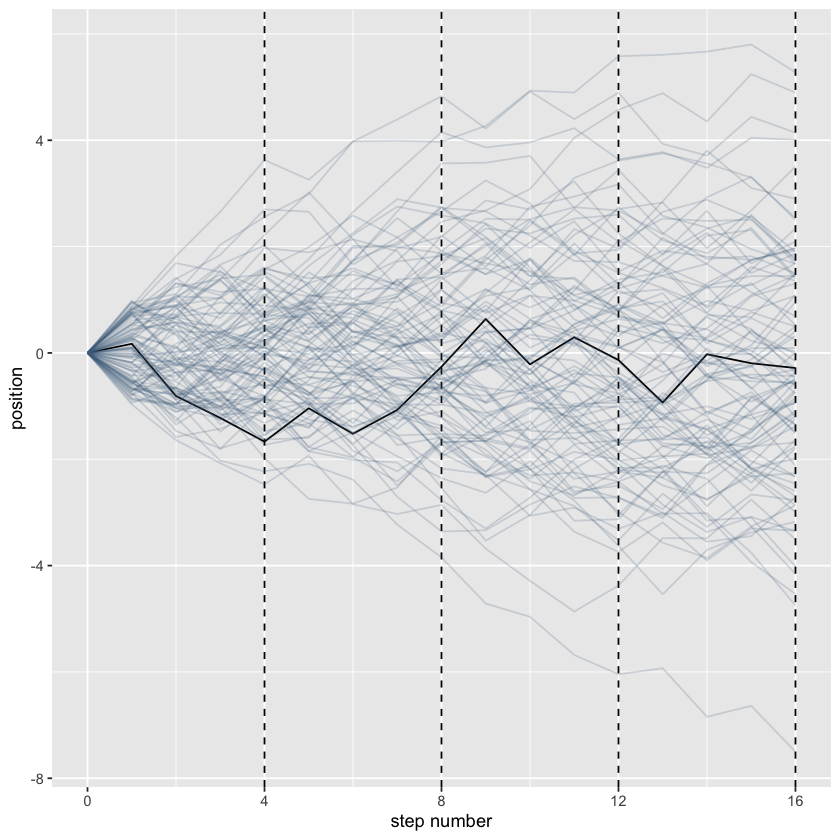

In [33]:
ggplot(data = pos, 
       aes(x = step, y = position, group = person)) +
  geom_vline(xintercept = c(4, 8, 12, 16), linetype = 2) +
  geom_line(aes(color = person < 2, alpha  = person < 2)) +
  scale_color_manual(values = c("skyblue4", "black")) +
  scale_alpha_manual(values = c(1/5, 1)) +
  scale_x_continuous("step number", breaks = c(0, 4, 8, 12, 16)) +
  theme(legend.position = "none")

sd      
1 2.180408

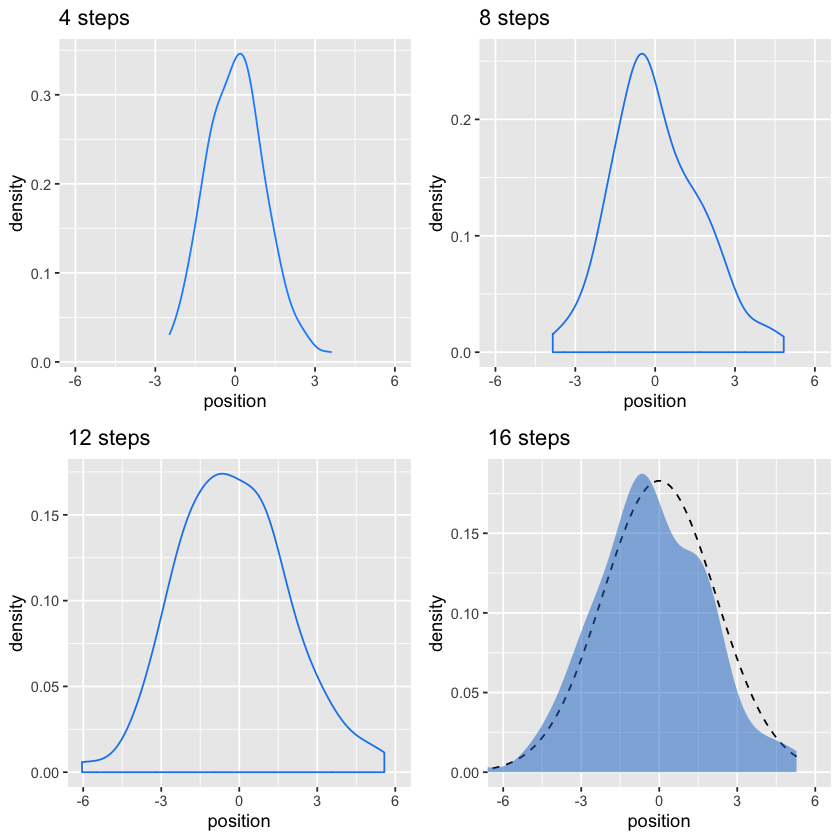

In [32]:
p1 =
  filter(pos, step == 4) %>%
  ggplot(aes(x = position)) +
  geom_line(stat = "density", color = "dodgerblue1") +
  coord_cartesian(xlim = -6:6) +
  labs(title = "4 steps")

p2 = 
  filter(pos, step == 8) %>%
  ggplot(aes(x = position)) +
  geom_density(color = "dodgerblue2") +
  coord_cartesian(xlim = -6:6) +
  labs(title = "8 steps")

p3 = 
  filter(pos, step == 12) %>%
  ggplot(aes(x = position)) +
  geom_density(color = "dodgerblue2") +
  coord_cartesian(xlim = -6:6) +
  labs(title = "12 steps")

p4 = 
  filter(pos, step == 16) %>%
  ggplot(aes(x = position)) +
  stat_function(fun = dnorm, 
                args = list(mean = 0, sd = 2.180408),
                linetype = 2) +  # 2.180408 came from the previous code block
  geom_density(color = "transparent", fill = "dodgerblue3", alpha = 1/2) +
  coord_cartesian(xlim = -6:6) +
  labs(title = "16 steps",
       y     = "density")

cowplot::plot_grid(p1, p2, p3,p4, nrow = 2, ncol = 2)

pos %>%
  filter(step == 16) %>%
  summarise(sd = sd(position))

## 相乘得正态

In [30]:
prod(1 + runif(12, 0, 0.1))  #返回乘数结果

[1] 1.804185

In [45]:
tibble(a   = 1,
       b   = runif(12, 0, 0.1)) %>% 
  mutate(c = a + b) %>% 
  summarise(p = prod(c))

p       
1 1.582587

`purrr::map`——Apply a function to each element of a vector
- map()          # 返回一个列表（list）
- map_lgl()    # 返回一个逻辑型向量
- map_int()    # 返回一个整数型向量
- map_dbl()   # 返回双精度数值向量
- map_chr()   # 返回字符串向量  

```R
numbers <- list(11, 12, 13, 14)
map_dbl(numbers, sqrt)
```
> [1] 3.316625 3.464102 3.605551 3.741657

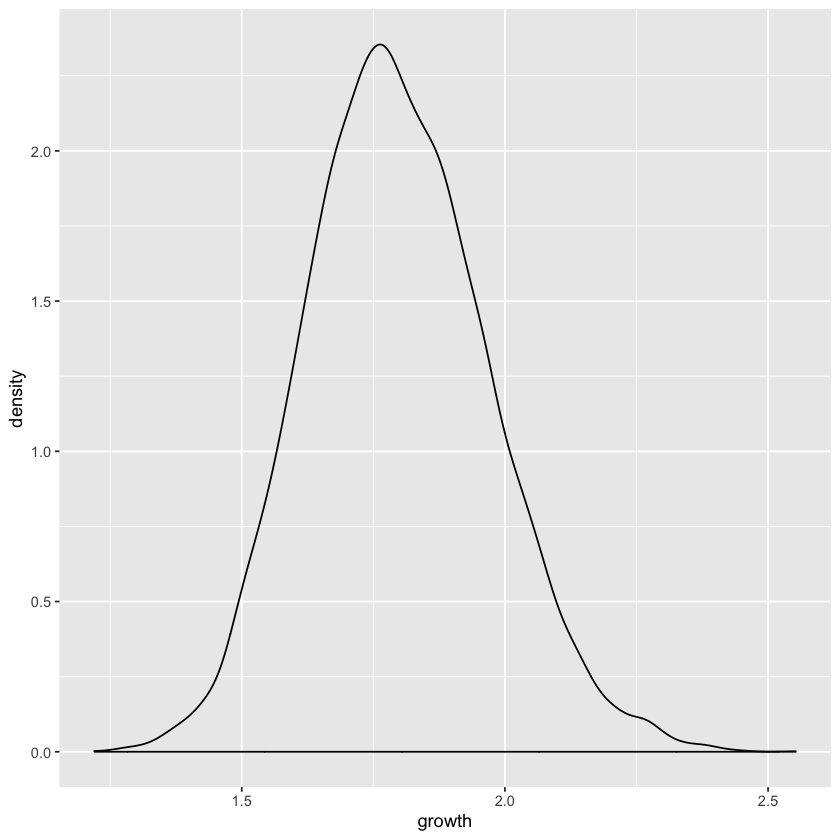

In [46]:
set.seed(4)
growth <- 
  tibble(growth = map_dbl(1:10000, ~ prod(1 + runif(12, 0, 0.1))))

ggplot(data = growth, aes(x = growth)) +
  geom_density()

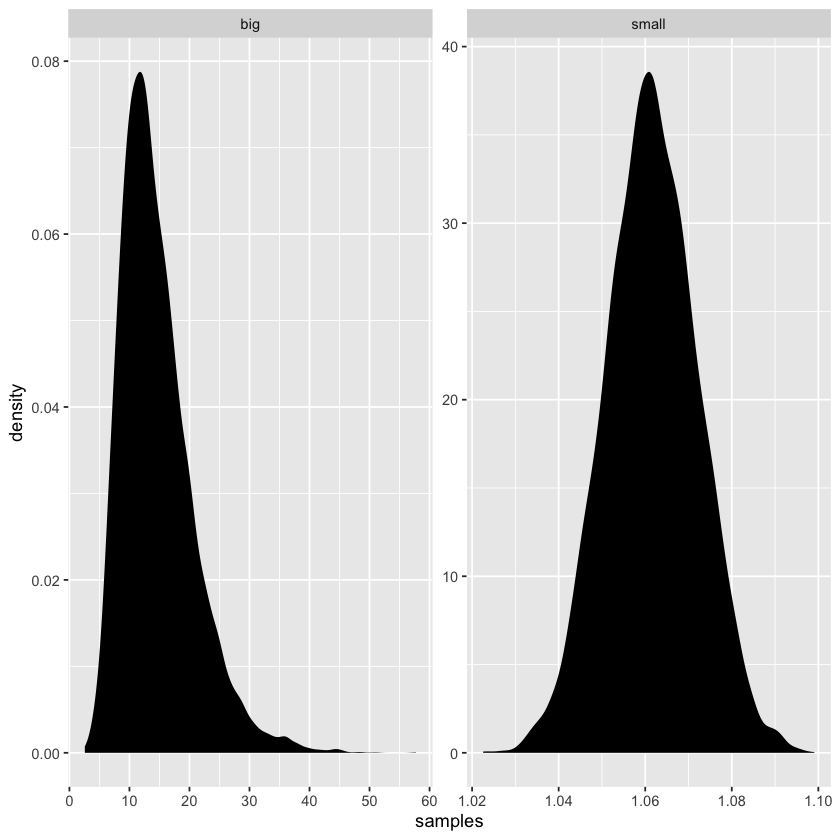

In [49]:
# simulate
set.seed(4)

samples <-
  tibble(big   = map_dbl(1:10000, ~ prod(1 + runif(12, 0, 0.5))),
         small = map_dbl(1:10000, ~ prod(1 + runif(12, 0, 0.01)))) %>% 
  # wrangle
  gather(distribution, samples) 

# plot
samples %>% 
  ggplot(aes(x = samples)) +
  geom_density(fill = "black", color = "transparent") +
  facet_wrap(~distribution, scales = "free") 

## 相乘取对数得正态

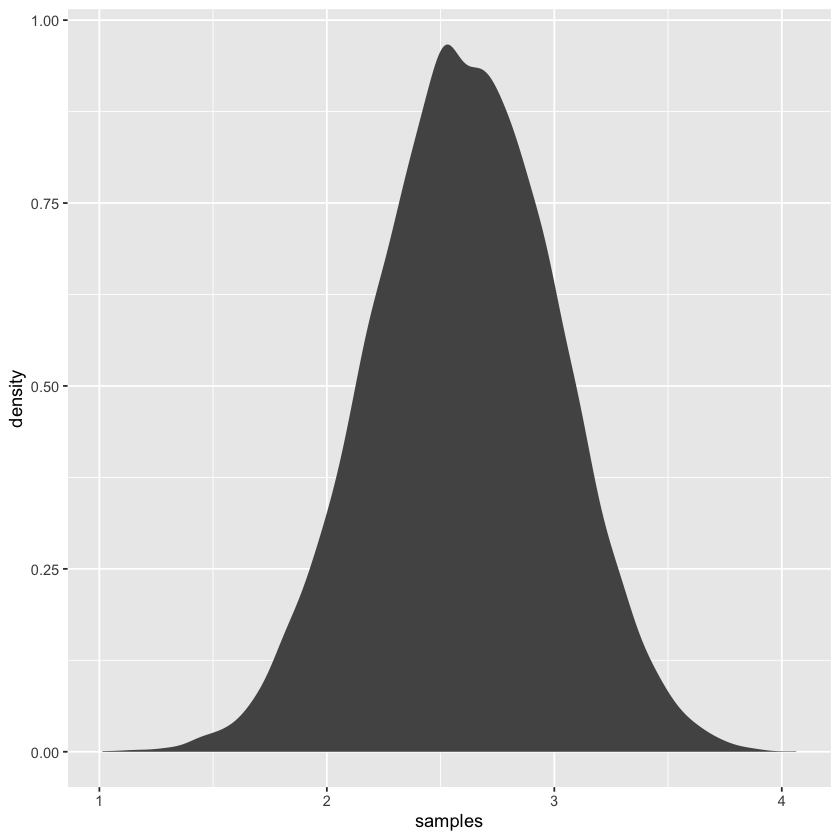

In [56]:
tibble(samples = map_dbl(1:1e4, ~ log(prod(1 + runif(12, 0, 0.5))))) %>% 
  ggplot(aes(x = samples)) +
  geom_density(color = "transparent", 
               fill = "gray33")

# 描述模型的语言
\begin{aligned} \text { criterion }_{i} & \sim \operatorname{Normal}\left(\mu_{i}, \sigma\right) \\ \mu_{i} &=\beta \times \text { predictor }_{i} \\ \beta & \sim \operatorname{Normal}(0,10) \\ \sigma & \sim \text { HalfCauchy }(0,1) \end{aligned}

In [2]:
n_points <- 100

d <-
  tibble(w          = 6, 
         n          = 9,
         p_grid     = seq(from = 0, to = 1, length.out = n_points)) %>% 
  mutate(prior      = dunif(p_grid, 0, 1),
         likelihood = dbinom(w, n, p_grid)) %>% 
  mutate(posterior  = likelihood * prior / sum(likelihood * prior))

head(d)

w n p_grid     prior likelihood   posterior   
1 6 9 0.00000000 1     0.000000e+00 0.000000e+00
2 6 9 0.01010101 1     8.654476e-11 8.741894e-12
3 6 9 0.02020202 1     5.371032e-09 5.425284e-10
4 6 9 0.03030303 1     5.930670e-08 5.990575e-09
5 6 9 0.04040404 1     3.229188e-07 3.261806e-08
6 6 9 0.05050505 1     1.193345e-06 1.205399e-07

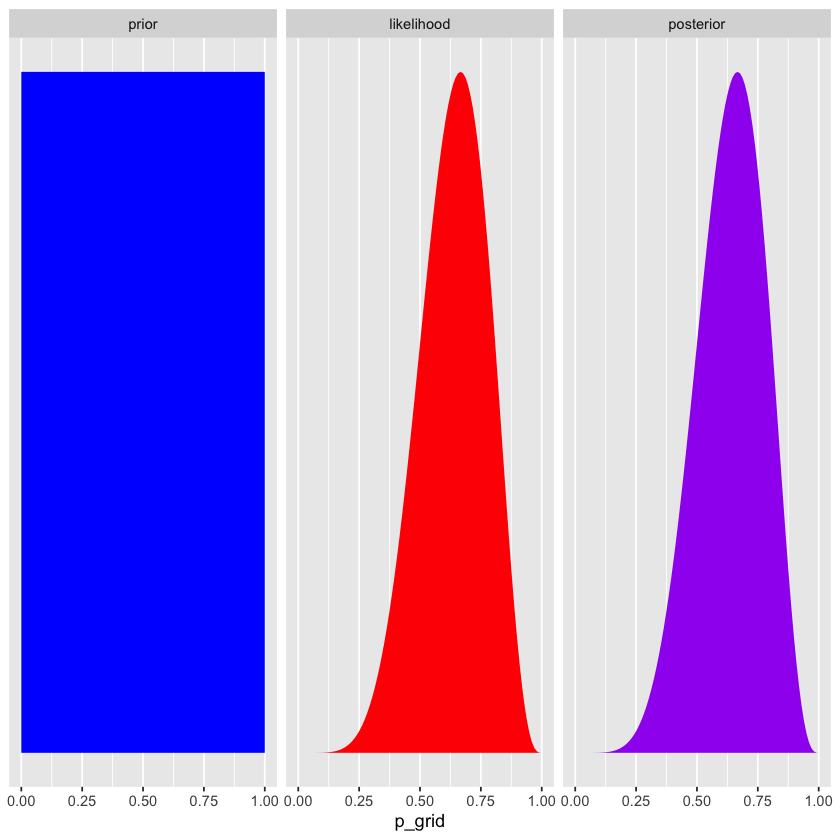

In [58]:
d %>% 
  select(-w, -n) %>%   #选取除去 w, n 后的其它列
  gather(key, value, -p_grid) %>% 
  # this line allows us to dictate the order the panels will appear in
  mutate(key = factor(key, levels = c("prior", "likelihood", "posterior"))) %>% 
  
  ggplot(aes(x = p_grid, ymin = 0, ymax = value, fill = key)) +
  geom_ribbon() +
  scale_fill_manual(values = c("blue", "red", "purple")) +
  scale_y_continuous(NULL, breaks = NULL) +
  theme(legend.position = "none") +
  facet_wrap(~key, scales = "free")

# 身高的高斯模型

## Data

In [7]:
library(rethinking)
data(Howell1)
d <- Howell1
rm(Howell1)
detach(package:rethinking, unload = T)
library(brms)    #brms 与 rethinking的部分函数有冲突， 故分别加载

In [8]:
head(d)

height  weight   age male
1 151.765 47.82561 63  1   
2 139.700 36.48581 63  0   
3 136.525 31.86484 65  0   
4 156.845 53.04191 41  1   
5 145.415 41.27687 51  0   
6 163.830 62.99259 35  1

In [5]:
d.adult <- 
  d %>%
  filter(age >= 18)
head(d.adult)

height  weight   age male
1 151.765 47.82561 63  1   
2 139.700 36.48581 63  0   
3 136.525 31.86484 65  0   
4 156.845 53.04191 41  1   
5 145.415 41.27687 51  0   
6 163.830 62.99259 35  1

## Model

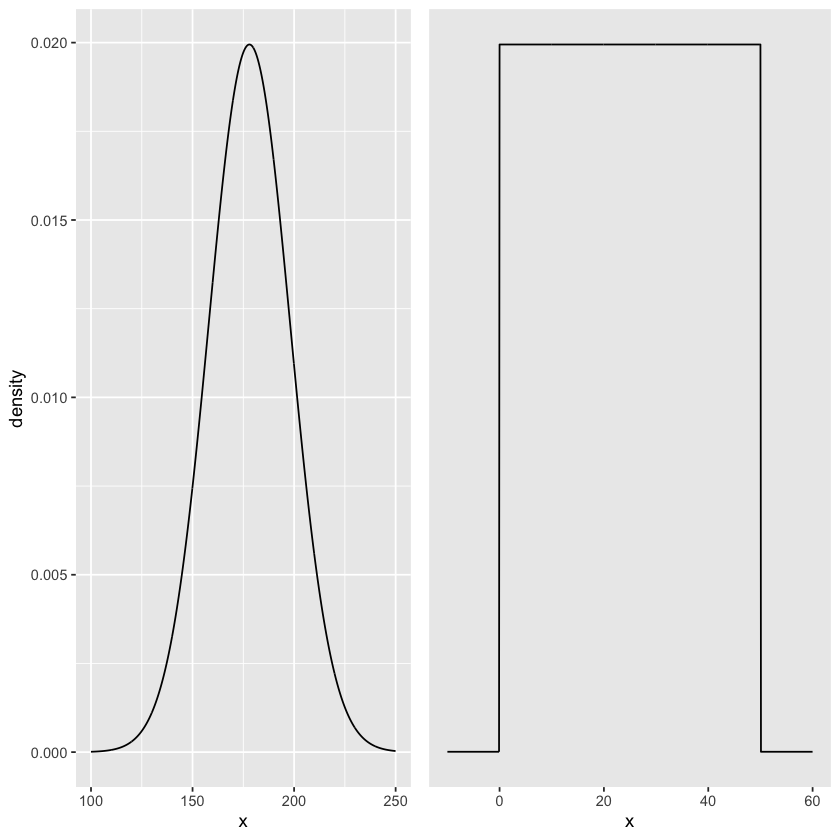

In [5]:
p1 = ggplot(data = tibble(x = seq(from = 100, to = 250, by = .1)), 
       aes(x = x, y = dnorm(x, mean = 178, sd = 20))) +
  geom_line() +
  ylab("density")



p2 = ggplot(data = tibble(x = seq(from = -10, to = 60, by = .1)),
            aes(x = x, y = dunif(x, min = 0, max = 50))) +
  geom_line() +
  scale_y_continuous(NULL, breaks = NULL) +
  theme(panel.grid = element_blank())

cowplot::plot_grid(p1, p2, ncol = 2)

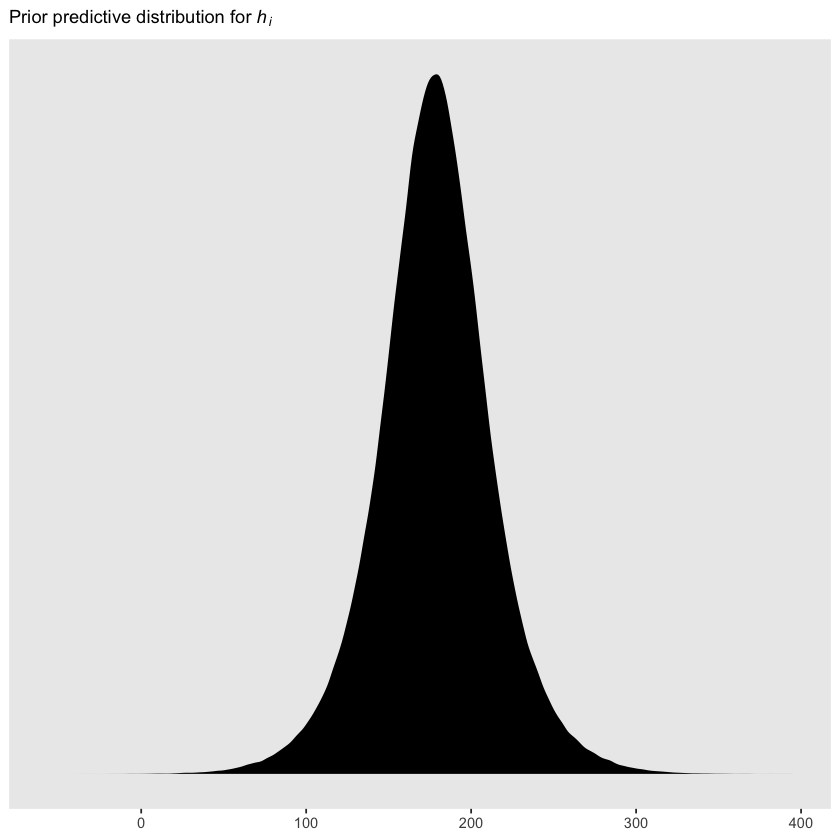

In [6]:
n <- 1e6
# 获得先验分布
set.seed(4)
tibble(sample_mu    = rnorm(n, mean = 178,       sd = 20),
       sample_sigma = runif(n, min = 0,         max = 50)) %>% 
  mutate(x          = rnorm(n, mean = sample_mu, sd = sample_sigma)) %>% 
  
  ggplot(aes(x = x)) +
  geom_density(fill = "black", size = 0) +
  scale_y_continuous(NULL, breaks = NULL) +
  labs(subtitle = expression(paste("Prior predictive distribution for ", italic(h[i]))),
       x        = NULL) +
  theme(panel.grid = element_blank())

## 后验分布的网格近似

In [7]:
n <- 201

d_grid <-
  tibble(mu    = seq(from = 140, to = 160, length.out = n),
         sigma = seq(from = 4,   to = 9,   length.out = n)) %>% 
  # mu 和 sigma 交叉组合
  expand(mu, sigma)

head(d_grid)

mu  sigma
1 140 4.000
2 140 4.025
3 140 4.050
4 140 4.075
5 140 4.100
6 140 4.125

`d_grid`中包含$\sigma$和$\mu$的后验概率

In [8]:
grid_function <- function(mu, sigma){
  dnorm(d.adult$height, mean = mu, sd = sigma, log = T) %>%
    sum()
}       #给出所有身高在给定mu,sigma下的概率函数，probabilities p are given as log(p)，算出后求和
d_grid <-
  d_grid %>% 
  mutate(log_likelihood = map2(mu, sigma, grid_function)) %>%     #对数似然(作为分母)，因为数据集很大时单个事件概率极低，易下溢
  unnest() %>% 
  mutate(prior_mu       = dnorm(mu,    mean = 178, sd  = 20, log = T),
         prior_sigma    = dunif(sigma, min  = 0,   max = 50, log = T)) %>% 
  mutate(product        = log_likelihood + prior_mu + prior_sigma) %>%     #对数尺度下变成相加
  mutate(probability    = exp(product - max(product)))    #最大值即为Pr的积分值
  
head(d_grid)

Warning message:
“`cols` is now required.
Please use `cols = c(log_likelihood)`”


mu  sigma log_likelihood prior_mu  prior_sigma product   probability
1 140 4.000 -3812.776      -5.719671 -3.912023   -3822.407 0          
2 140 4.025 -3777.801      -5.719671 -3.912023   -3787.433 0          
3 140 4.050 -3743.499      -5.719671 -3.912023   -3753.131 0          
4 140 4.075 -3709.853      -5.719671 -3.912023   -3719.484 0          
5 140 4.100 -3676.846      -5.719671 -3.912023   -3686.478 0          
6 140 4.125 -3644.464      -5.719671 -3.912023   -3654.096 0

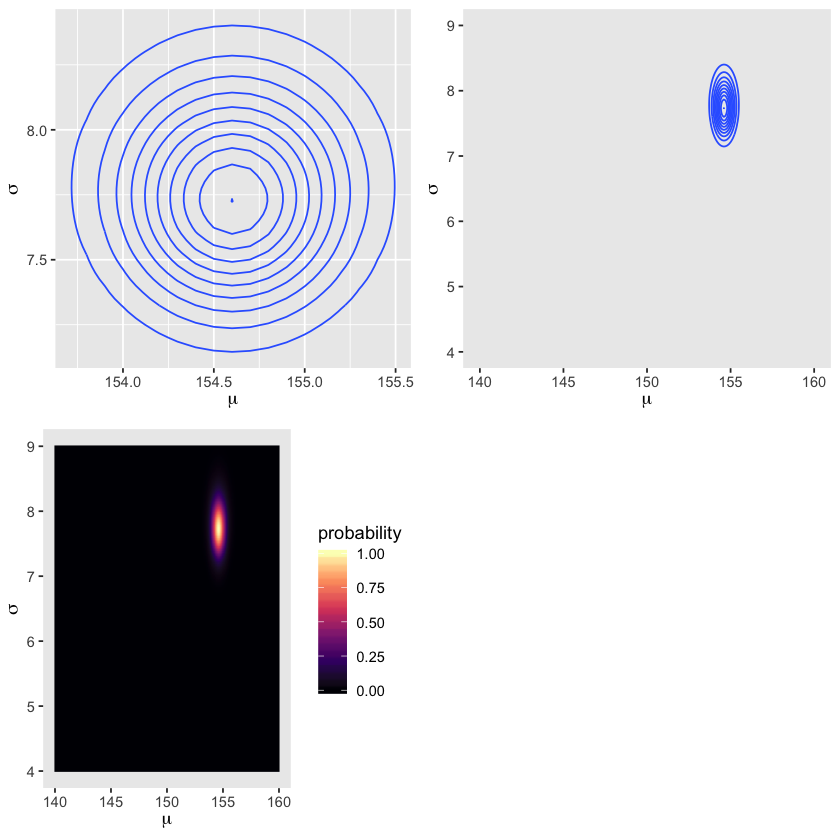

In [9]:
p3 = ggplot(data = d_grid, aes(x = mu, y = sigma, z = probability)) + 
  geom_contour() +
  labs(x = expression(mu),
       y = expression(sigma))
p4 = ggplot(data = d_grid, aes(x = mu, y = sigma, z = probability)) + 
  geom_contour() +
  labs(x = expression(mu),
       y = expression(sigma)) +
  coord_cartesian(xlim = range(d_grid$mu),
                  ylim = range(d_grid$sigma)) +
  theme(panel.grid = element_blank())
p5 = ggplot(data = d_grid, aes(x = mu, y = sigma)) + 
  geom_raster(aes(fill = probability),
              interpolate = T) +
  scale_fill_viridis_c(option = "A") +
  labs(x = expression(mu),
       y = expression(sigma)) +
  theme(panel.grid = element_blank())

cowplot::plot_grid(p3, p4, p5, nrow = 1, ncol = 3)

## 后验分布中抽样

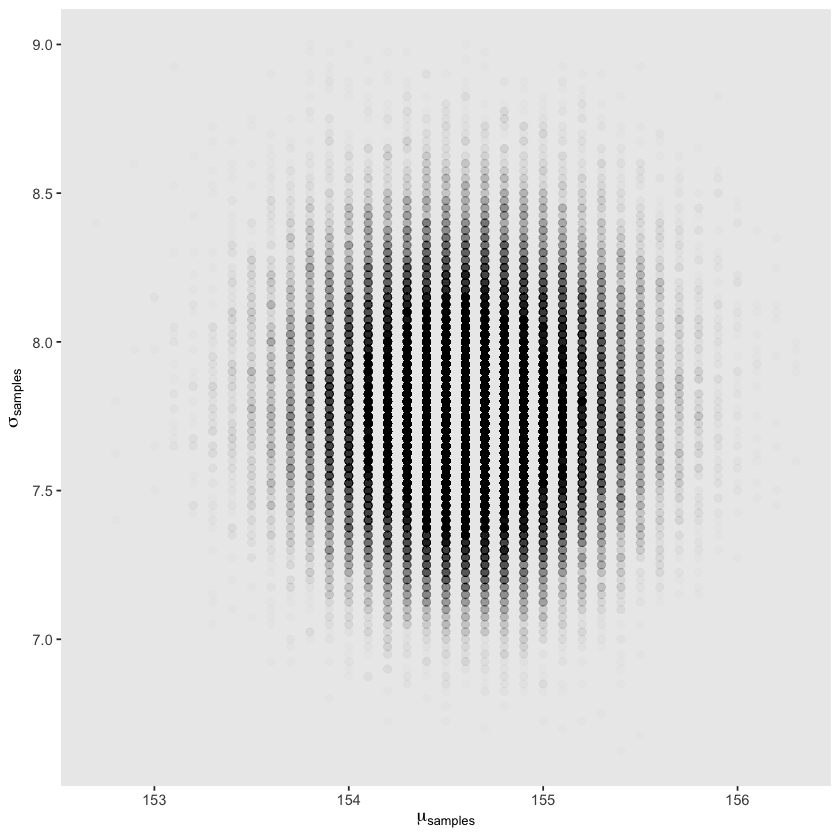

In [10]:
set.seed(4)
d_grid_samples <- 
  d_grid %>% 
  sample_n(size = 1e5, replace = T, weight = probability)  #有放回抽样

d_grid_samples %>% 
  ggplot(aes(x = mu, y = sigma)) + 
  geom_point(size = 2, alpha = 1/100) +
  scale_fill_viridis_c() +
  labs(x = expression(mu[samples]),
       y = expression(sigma[samples])) +
  theme(panel.grid = element_blank())

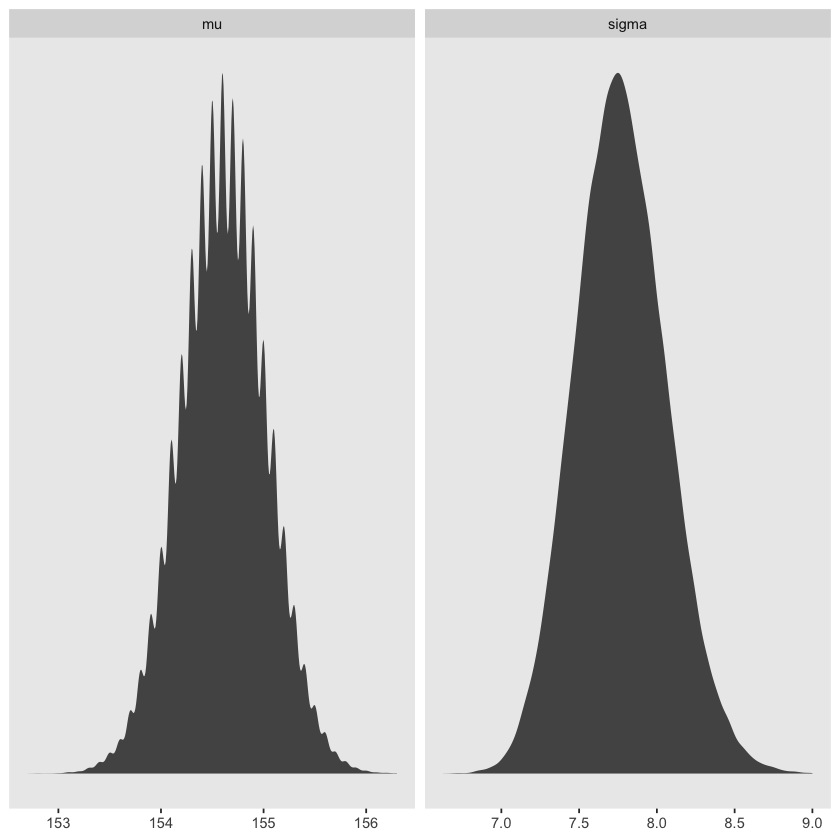

In [11]:
d_grid_samples %>% 
  select(mu, sigma) %>% 
  gather() %>% 

  ggplot(aes(x = value)) + 
  geom_density(fill = "grey33", size = 0) +
  scale_y_continuous(NULL, breaks = NULL) +
  xlab(NULL) +
  theme(panel.grid = element_blank()) +
  facet_wrap(~key, scales = "free")

In [12]:
library(tidybayes)

d_grid_samples %>% 
  select(mu, sigma) %>% 
  gather() %>% 
  group_by(key) %>% 
  mode_hdi(value)

key   value      .lower  .upper  .width .point .interval
1 mu    154.601021 153.800 155.400 0.95   mode   hdi      
2 sigma   7.750522   7.175   8.325 0.95   mode   hdi

### 小样本下并不一定模拟出正态结果

In [13]:
d3 <- sample(d.adult$height, size = 20)
d3

[1] 142.8750 179.0700 140.3350 163.1950 161.9250 156.2100 154.3050 144.7800
 [9] 149.8600 163.1950 157.9880 151.9428 164.4650 153.0350 147.3200 154.9400
[17] 156.2100 160.6550 145.4150 157.4800

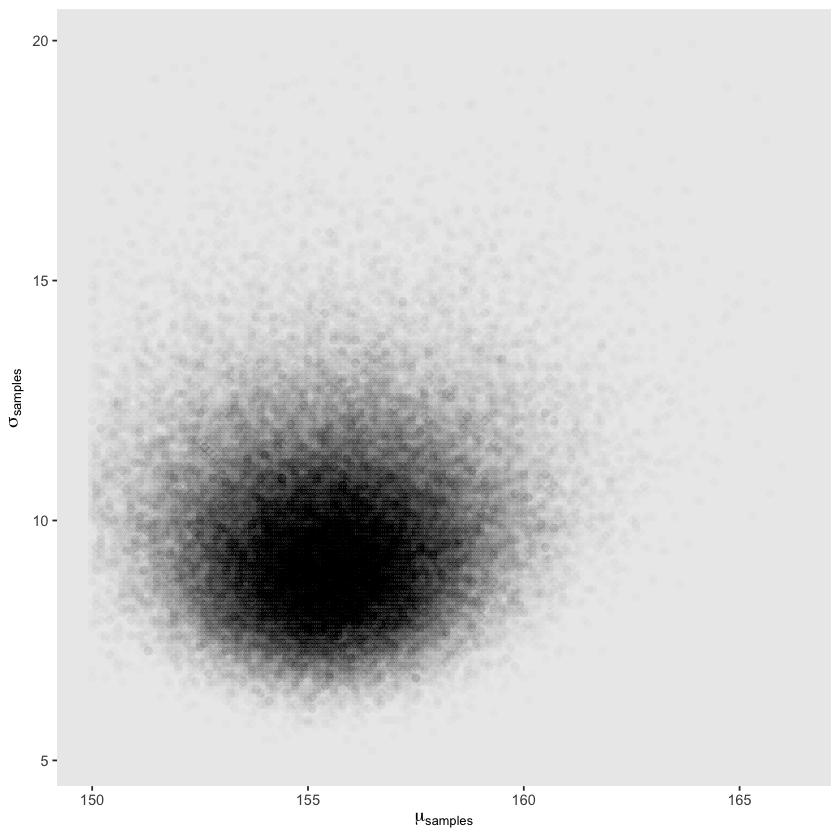

In [14]:
n <- 201

# note we've redefined the ranges of `mu` and `sigma`
d_grid <-
  tibble(mu    = seq(from = 150, to = 170, length.out = n),
         sigma = seq(from = 4,   to = 20,  length.out = n)) %>% 
  expand(mu, sigma)

grid_function <- function(mu, sigma){
  dnorm(d3, mean = mu, sd = sigma, log = T) %>% 
    sum()
}

d_grid <-
  d_grid %>% 
  mutate(log_likelihood = map2_dbl(mu, sigma, grid_function)) %>% 
  mutate(prior_mu       = dnorm(mu,    mean = 178, sd  = 20, log = T),
         prior_sigma    = dunif(sigma, min  = 0,   max = 50, log = T)) %>% 
  mutate(product        = log_likelihood + prior_mu + prior_sigma) %>% 
  mutate(probability    = exp(product - max(product)))

set.seed(4)
d_grid_samples <- 
  d_grid %>% 
  sample_n(size = 1e5, replace = T, weight = probability)

d_grid_samples %>% 
  ggplot(aes(x = mu, y = sigma)) + 
  geom_point(size = 2, alpha = 1/100) +
  scale_fill_viridis_c() +
  labs(x = expression(mu[samples]),
       y = expression(sigma[samples])) +
  theme(panel.grid = element_blank())

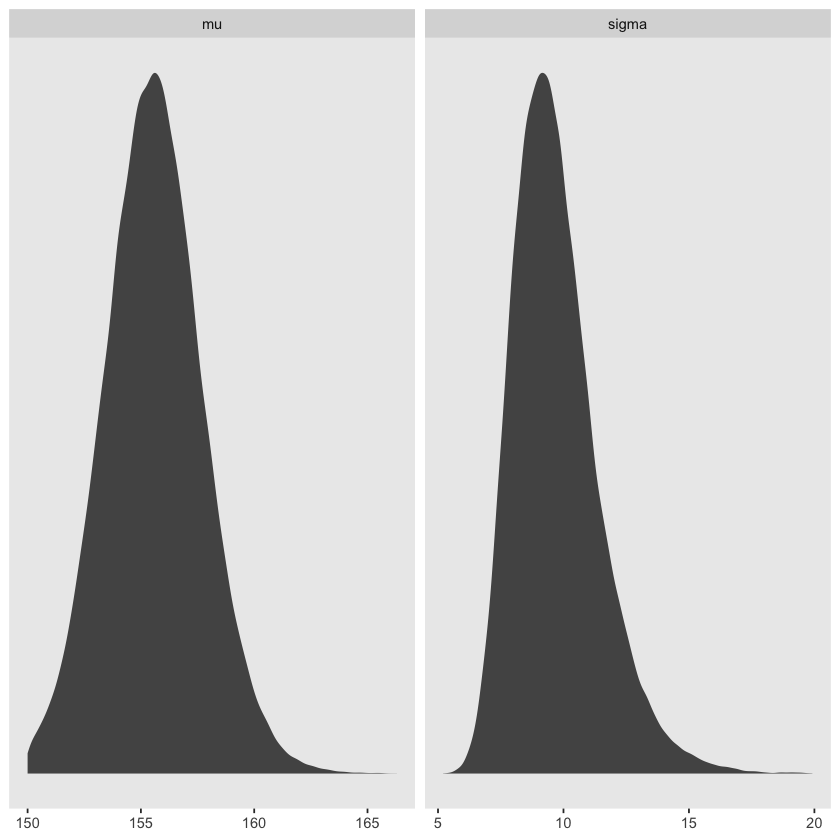

In [15]:
d_grid_samples %>% 
  select(mu, sigma) %>% 
  gather() %>% 

  ggplot(aes(x = value)) + 
  geom_density(fill = "grey33", size = 0) +
  scale_y_continuous(NULL, breaks = NULL) +
  xlab(NULL) +
  theme(panel.grid = element_blank()) +
  facet_wrap(~key, scales= "free")

### 使用`brm`

In [44]:
b4.1 <- 
  brm(data = d.adult, family = gaussian,    #高斯分布拟合
      height ~ 1,
      prior = c(prior(normal(178, 20), class = Intercept),
                prior(uniform(0, 50), class = sigma)),
      iter = 31000, warmup = 3e4, chains = 8, cores = 8,
      seed = 4)

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling



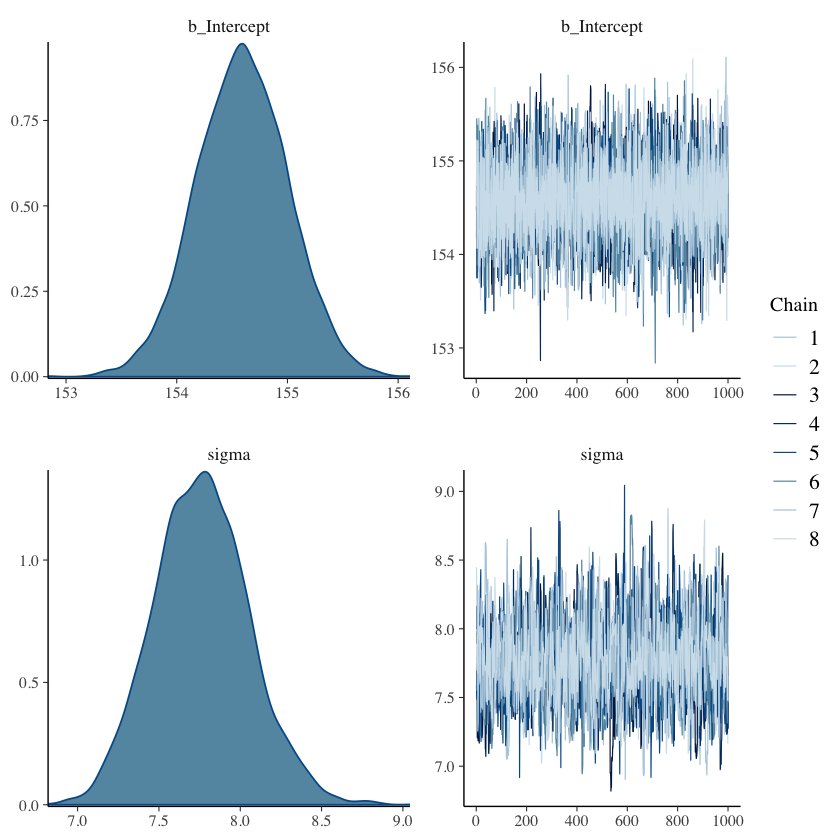

In [45]:
plot(b4.1)

In [46]:
summary(b4.1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: height ~ 1 
   Data: d.adult (Number of observations: 352) 
Samples: 8 chains, each with iter = 31000; warmup = 30000; thin = 1;
         total post-warmup samples = 8000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept   154.59      0.41   153.78   155.41 1.00     8417     5174

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     7.76      0.29     7.21     8.36 1.01     2054     2095

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

In [19]:
b4.2 <- 
  brm(data = d.adult, family = gaussian,
      height ~ 1,
      prior = c(prior(normal(178, .1), class = Intercept),    #使用σ=0.1的较窄的正态先验分布
                prior(uniform(0, 50), class = sigma)),
      iter = 3000, warmup = 2000, chains = 4, cores = 4,
      seed = 4)

Compiling the C++ model

Start sampling



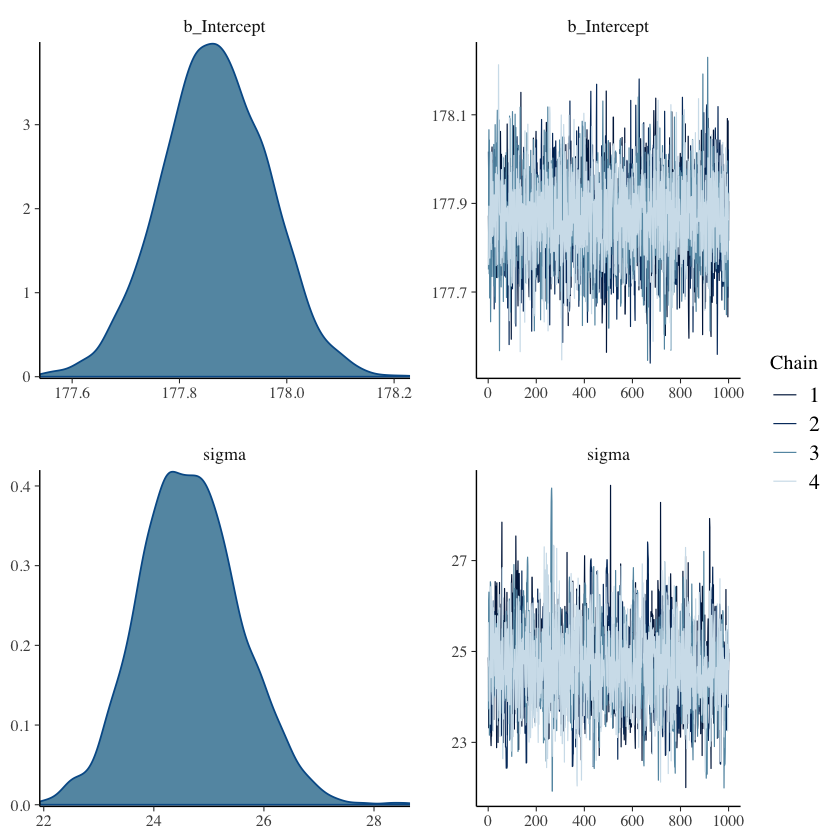

In [20]:
plot(b4.2)

In [21]:
summary(b4.2)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: height ~ 1 
   Data: d.adult (Number of observations: 352) 
Samples: 4 chains, each with iter = 3000; warmup = 2000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept   177.87      0.10   177.67   178.06 1.00     3860     2504

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma    24.66      0.93    22.91    26.52 1.00     1512     1443

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

In [96]:
launch_shinystan(b4.1)    #对HMC链进行详细诊断


Launching ShinyStan interface... for large models this  may take some time.

Loading required package: shiny


Listening on http://127.0.0.1:3980



将$\sigma$默认值设置为半Cauchy分布时，HMC会更好地工作

In [23]:
b4.1_half_cauchy <- 
  brm(data = d.adult, family = gaussian,
      height ~ 1,
      prior = c(prior(normal(178, 20), class = Intercept),
                prior(cauchy(0, 1), class = sigma)),    #sigma使用柯西分布拟合
      iter = 31000, warmup = 3e4, chains = 8, cores = 8,
      seed = 4)

Compiling the C++ model

Start sampling



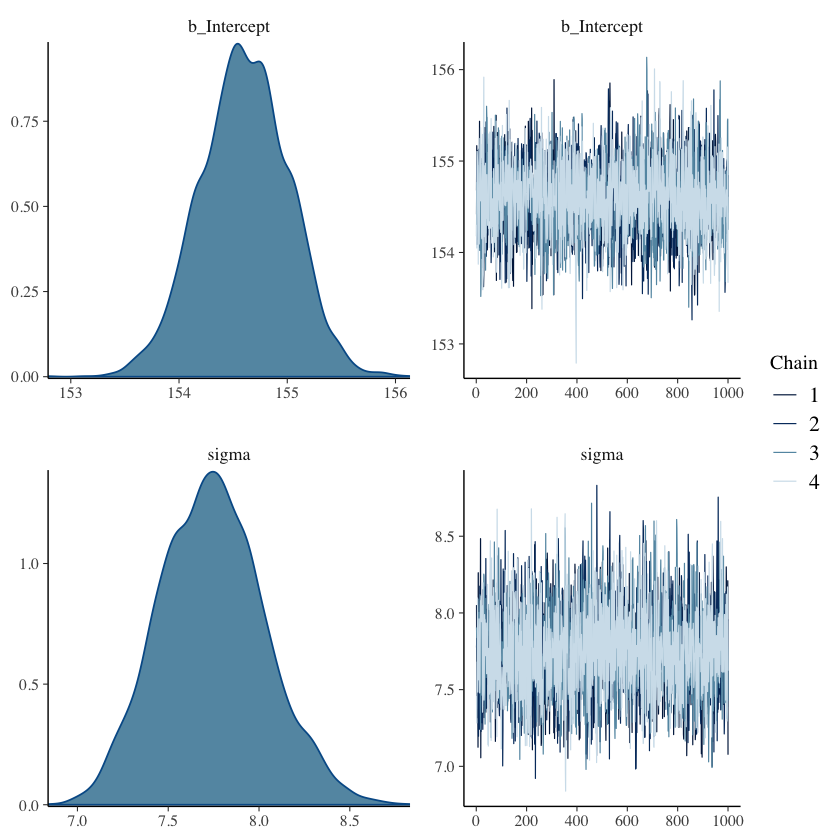

In [94]:
plot(b4.1_half_cauchy)

In [95]:
print(b4.1_half_cauchy)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: height ~ 1 
   Data: d.adult (Number of observations: 352) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept   154.61      0.41   153.81   155.40 1.00     3277     2424

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     7.74      0.29     7.21     8.34 1.00     3525     2627

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


In [98]:
b4.1_half_cauchy$fit

Inference for Stan model: 50d082a7668b36f6e62550f4f9560747.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean   sd     2.5%      25%      50%      75%    97.5%
b_Intercept   154.61    0.01 0.41   153.81   154.34   154.61   154.88   155.40
sigma           7.74    0.00 0.29     7.21     7.54     7.74     7.93     8.34
Intercept     154.61    0.01 0.41   153.81   154.34   154.61   154.88   155.40
lp__        -1227.49    0.02 0.95 -1230.00 -1227.88 -1227.21 -1226.81 -1226.54
            n_eff Rhat
b_Intercept  3247    1
sigma        3500    1
Intercept    3247    1
lp__         1743    1

Samples were drawn using NUTS(diag_e) at Mon Feb 24 17:39:20 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [99]:
summary(b4.1_half_cauchy, prob = .95)   #展示95%置信区间

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: height ~ 1 
   Data: d.adult (Number of observations: 352) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
          Estimate Est.Error l-89% CI u-89% CI Rhat Bulk_ESS Tail_ESS
Intercept   154.61      0.41   153.96   155.24 1.00     3277     2424

Family Specific Parameters: 
      Estimate Est.Error l-89% CI u-89% CI Rhat Bulk_ESS Tail_ESS
sigma     7.74      0.29     7.29     8.23 1.00     3525     2627

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

## 使用`brms`拟合模型(二项逼近)

In [24]:
vcov(b4.1_half_cauchy)    #方差-协方差矩阵，brms只返回第一个元素

Intercept
Intercept 0.1661658

In [25]:
post <- posterior_samples(b4.1_half_cauchy)    #获取后验样本
head(post)

b_Intercept sigma    Intercept lp__     
1 154.6786    8.051124 154.6786  -1227.133
2 155.1678    7.460777 155.1678  -1227.938
3 154.8059    7.492012 154.8059  -1226.967
4 154.5193    8.035891 154.5193  -1227.089
5 154.8931    7.316433 154.8931  -1227.847
6 155.1126    7.900020 155.1126  -1227.420

In [31]:
select(post, b_Intercept:sigma) %>% 
  cov()    #协方差

b_Intercept   sigma        
b_Intercept  0.1661658018 -0.0007004767
sigma       -0.0007004767  0.0832359724

In [27]:
select(post, b_Intercept:sigma) %>%
  cov() %>%
  diag()   #获取对角元素

b_Intercept       sigma 
 0.16616580  0.08323597

In [28]:
post %>%
select(b_Intercept, sigma) %>%
  cor()    #相关系数矩阵

b_Intercept  sigma       
b_Intercept  1.000000000 -0.005956173
sigma       -0.005956173  1.000000000

In [35]:
summary(post[1:2])

  b_Intercept        sigma      
 Min.   :152.8   Min.   :6.838  
 1st Qu.:154.3   1st Qu.:7.537  
 Median :154.6   Median :7.738  
 Mean   :154.6   Mean   :7.743  
 3rd Qu.:154.9   3rd Qu.:7.932  
 Max.   :156.1   Max.   :8.832  

In [39]:
apply(post[, 1:2], 2, quantile, probs = c(.5, .025, .75))
t(apply(post[, 1:2], 2, quantile, probs = c(.5, .025, .75)))

b_Intercept sigma   
50%  154.6053    7.738411
2.5% 153.8064    7.205024
75%  154.8812    7.931603

50%        2.5%       75%       
b_Intercept 154.605262 153.806385 154.881238
sigma         7.738411   7.205024   7.931603

In [40]:
post %>%
  select(-lp__) %>% 
  gather(parameter) %>%
  group_by(parameter) %>%
  summarise(mean = mean(value),
            SD   = sd(value),
            `2.5_percentile`  = quantile(value, probs = .025),
            `97.5_percentile` = quantile(value, probs = .975)) %>%
  mutate_if(is.numeric, round, digits = 2)

parameter   mean   SD   2.5_percentile 97.5_percentile
1 b_Intercept 154.61 0.41 153.81         155.40         
2 Intercept   154.61 0.41 153.81         155.40         
3 sigma         7.74 0.29   7.21           8.34

In [41]:
posterior_summary(b4.1_half_cauchy)

Estimate     Est.Error Q2.5         Q97.5       
b_Intercept   154.607579 0.4076344   153.806385   155.395943
sigma           7.743143 0.2885065     7.205024     8.335414
Intercept     154.607579 0.4076344   153.806385   155.395943
lp__        -1227.492023 0.9523241 -1230.000431 -1226.541784

In [42]:
post %>% 
  select(-lp__) %>% 
  gather(parameter) %>%
  group_by(parameter) %>%
  mean_qi(value)

parameter   value      .lower     .upper     .width .point .interval
1 b_Intercept 154.607579 153.806385 155.395943 0.95   mean   qi       
2 Intercept   154.607579 153.806385 155.395943 0.95   mean   qi       
3 sigma         7.743143   7.205024   8.335414 0.95   mean   qi

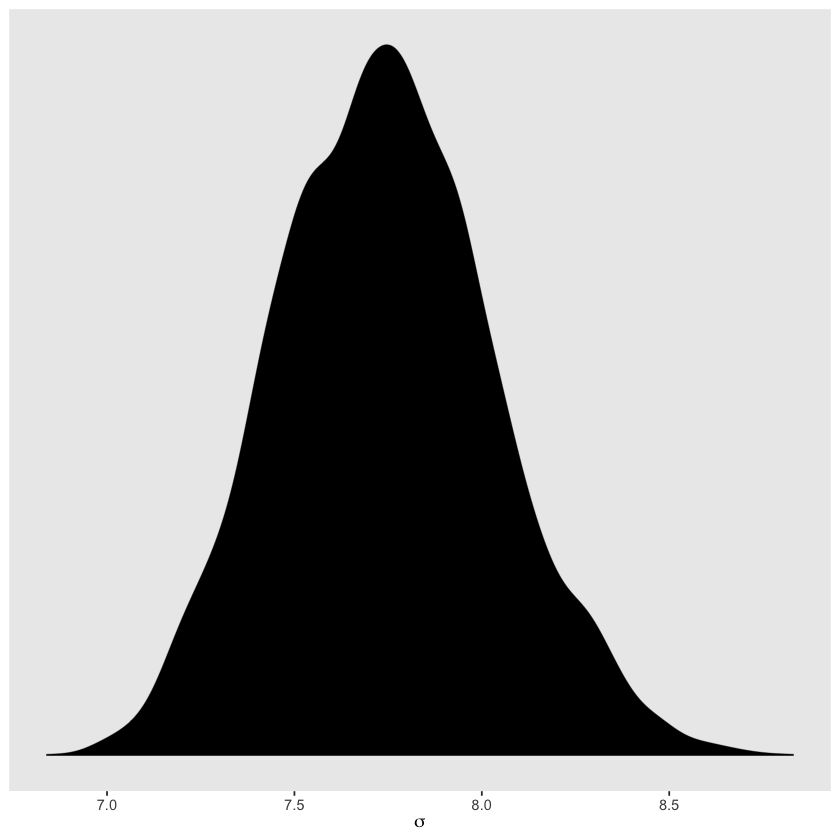

In [43]:
ggplot(data = post, 
       aes(x = sigma)) +
  geom_density(size = 1/10, fill = "black") +
  scale_y_continuous(NULL, breaks = NULL) +
  xlab(expression(sigma)) +
  theme(panel.grid = element_blank())

# 添加预测变量

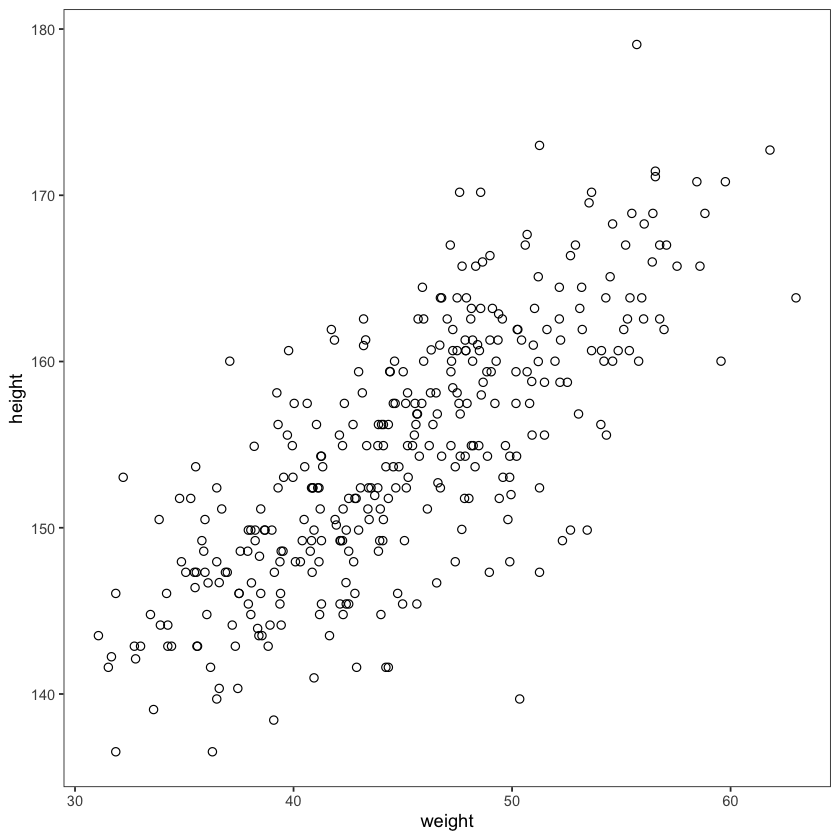

In [48]:
ggplot(data = d.adult, 
       aes(x = weight, y = height)) +
  geom_point(shape = 1, size = 2) +
  theme_bw() +
  theme(panel.grid = element_blank())    #看起来身高与体重存在某种相关

表述|意义|公式
:-:|:-:|:-:
$h_{i}\sim\text{Normal}\left(\mu_{i},\sigma\right)$|似然函数|`family = gaussian`
$\mu_{i} = \alpha+\beta x_{i}$|线性模型|`height ~ 1 + weight`
$\alpha \sim \text { Normal }(178,100)$|$Prior_\alpha$|`prior(normal(156, 100), class = Intercept`
$\beta \sim \operatorname{Normal}(0,10)$|$Prior_\beta$|`prior(normal(0, 10), class = b)`
$\sigma \sim \text { Uniform }(0,50)$|$Prior_\sigma$|`prior(uniform(0, 50), class = sigma)`

In [53]:
head(d.adult)

height  weight   age male
1 151.765 47.82561 63  1   
2 139.700 36.48581 63  0   
3 136.525 31.86484 65  0   
4 156.845 53.04191 41  1   
5 145.415 41.27687 51  0   
6 163.830 62.99259 35  1

In [30]:
b4.3 <- 
  brm(data = d.adult, family = gaussian,
      height ~ 1 + weight,
      prior = c(prior(normal(156, 100), class = Intercept),
                prior(normal(0, 10), class = b),
                prior(uniform(0, 50), class = sigma)),
      iter = 51000, warmup = 50000, chains = 4, cores = 4,
      seed = 4)

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling



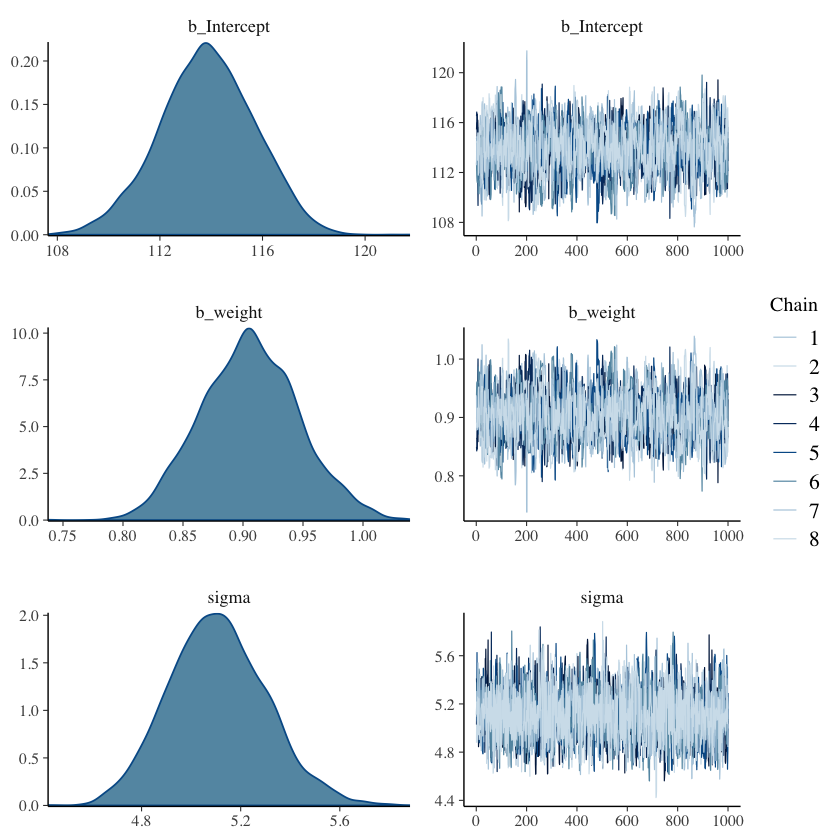

In [20]:
plot(b4.3)

## 估计值表格

In [56]:
posterior_summary(b4.3)

Estimate      Est.Error  Q2.5          Q97.5        
b_Intercept   113.8480333 1.84761654   110.1423800   117.3371075
b_weight        0.9058158 0.04057316     0.8289256     0.9876794
sigma           5.1079962 0.19684249     4.7412328     5.5170762
Intercept     154.6011270 0.27283008   154.0690164   155.1396928
lp__        -1083.5355628 1.20609670 -1086.7055796 -1082.1567711

In [57]:
posterior_summary(b4.3)[1:3, ]

Estimate    Est.Error  Q2.5        Q97.5      
b_Intercept 113.8480333 1.84761654 110.1423800 117.3371075
b_weight      0.9058158 0.04057316   0.8289256   0.9876794
sigma         5.1079962 0.19684249   4.7412328   5.5170762

In [52]:
posterior_samples(b4.3) %>%
  select(-lp__) %>%
    cor() %>%
    round(digits = 2)

b_Intercept b_weight sigma Intercept
b_Intercept  1.00       -0.99    0.00   0.15    
b_weight    -0.99        1.00    0.00  -0.01    
sigma        0.00        0.00    1.00   0.02    
Intercept    0.15       -0.01    0.02   1.00

### 中心化后进行拟合

In [6]:
d.adult <- 
  d.adult %>%
  mutate(weight_c = weight - mean(weight))

In [7]:
b4.4 <- 
  brm(data = d.adult, family = gaussian,
      height ~ 1 + weight_c,
      prior = c(prior(normal(178, 100), class = Intercept),
                prior(normal(0, 10), class = b),
                prior(uniform(0, 50), class = sigma)),
      iter = 56000, warmup = 55000, chains = 4, cores = 4,
      seed = 4)

Compiling the C++ model

Start sampling



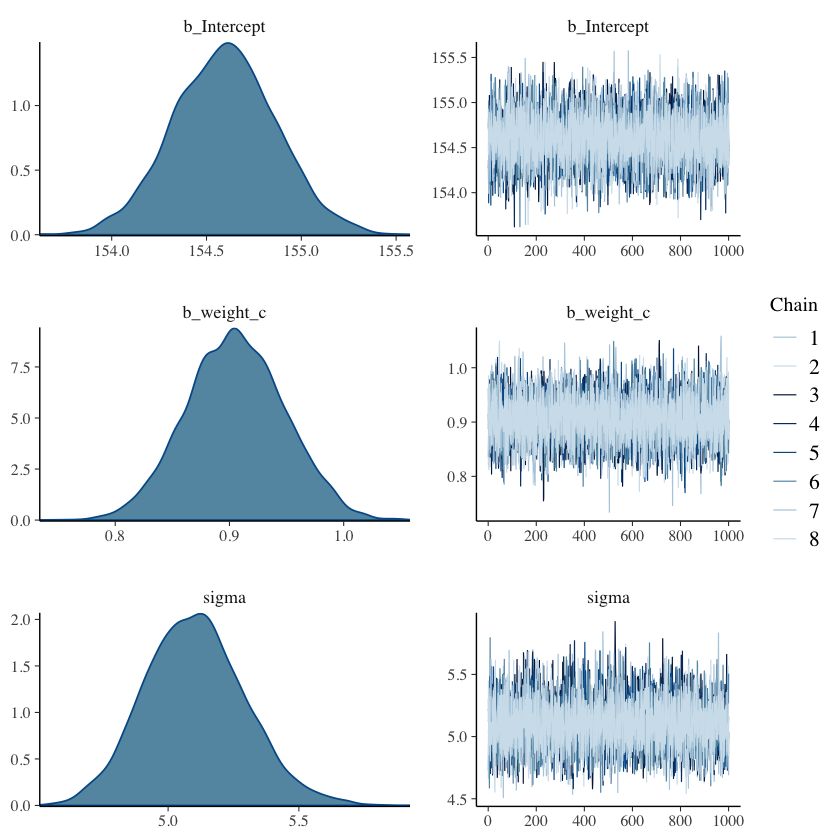

In [8]:
plot(b4.4)

In [61]:
posterior_summary(b4.4)[1:3, ]

Estimate    Est.Error  Q2.5       Q97.5      
b_Intercept 154.5967364 0.27186533 154.064215 155.1366660
b_weight_c    0.9055414 0.04274686   0.822869   0.9889055
sigma         5.1037483 0.19252815   4.742426   5.5036141

In [9]:
posterior_samples(b4.4) %>%
  select(-lp__) %>%
  cor() %>%
  round(digits = 2)    #中心化后各变量间相关基本为0

b_Intercept b_weight_c sigma Intercept
b_Intercept  1.00       -0.01      -0.02  1.00    
b_weight_c  -0.01        1.00       0.02 -0.01    
sigma       -0.02        0.02       1.00 -0.02    
Intercept    1.00       -0.01      -0.02  1.00

## 后验可视化

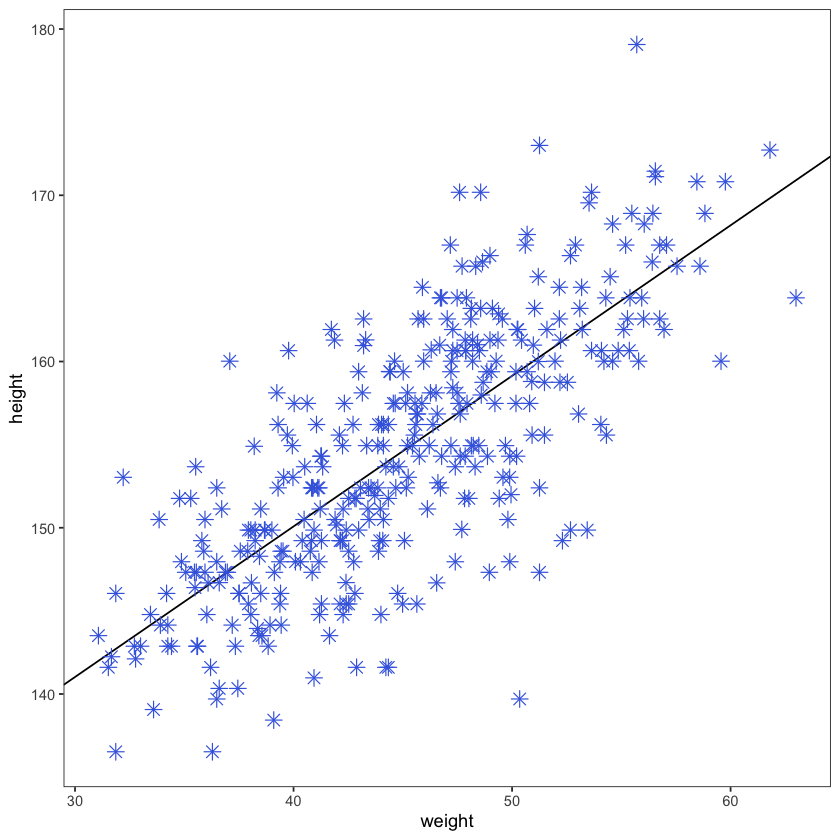

In [29]:
#vis
ggplot(d.adult, aes(x = weight, y = height)) +
geom_abline(intercept = fixef(b4.3)[1], 
          slope     = fixef(b4.3)[2]) +
geom_point(shape = 8, size = 3, color = "royalblue") +
theme_bw() +
theme(panel.grid = element_blank())

In [31]:
post <- posterior_samples(b4.3)

post %>%
  slice(1:5)  # this serves a similar function as `head()`

b_Intercept b_weight  sigma    Intercept lp__     
1 113.6902    0.9158099 4.927414 154.8929  -1083.048
2 113.8044    0.9157745 4.932099 155.0056  -1083.600
3 114.3667    0.8953508 5.133154 154.6490  -1082.132
4 114.9528    0.8834008 5.184174 154.6974  -1082.388
5 113.0629    0.9106666 5.070353 154.0342  -1084.228

### 添加后验线

In [32]:
n <- 10

b.10 <- 
  brm(data = d.adult %>%
        slice(1:n),  # note our tricky use of `n` and `slice()`
      family = gaussian,
      height ~ 1 + weight,
      prior = c(prior(normal(178, 100), class = Intercept),
                prior(normal(0, 10), class = b),
                prior(cauchy(0, 1), class = sigma)),
      iter = 2000, warmup = 1000, chains = 4, cores = 4,
      seed = 4)

n <- 50

b.50 <- 
  brm(data = d.adult %>%
        slice(1:n), 
      family = gaussian,
      height ~ 1 + weight,
      prior = c(prior(normal(178, 100), class = Intercept),
                prior(normal(0, 10), class = b),
                prior(cauchy(0, 1), class = sigma)),
      iter = 2000, warmup = 1000, chains = 4, cores = 4,
      seed = 4)

n <- 150

b.150 <- 
  brm(data = d.adult %>%
        slice(1:n), 
      family = gaussian,
      height ~ 1 + weight,
      prior = c(prior(normal(178, 100), class = Intercept),
                prior(normal(0, 10), class = b),
                prior(cauchy(0, 1), class = sigma)),
      iter = 2000, warmup = 1000, chains = 4, cores = 4,
      seed = 4)

n <- 352

b.352 <- 
  brm(data = d.adult %>%
        slice(1:n), 
      family = gaussian,
      height ~ 1 + weight,
      prior = c(prior(normal(178, 100), class = Intercept),
                prior(normal(0, 10), class = b),
                prior(cauchy(0, 1), class = sigma)),
      iter = 2000, warmup = 1000, chains = 4, cores = 4,
      seed = 4)

Compiling the C++ model

Start sampling

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling



 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: height ~ 1 + weight 
   Data: d.adult %>% slice(1:n) (Number of observations: 10) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept   109.61      7.38    95.50   124.51 1.00     3153     2331
weight        0.94      0.16     0.62     1.24 1.00     3121     2347

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     5.01      1.33     3.16     8.29 1.00     2320     2447

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


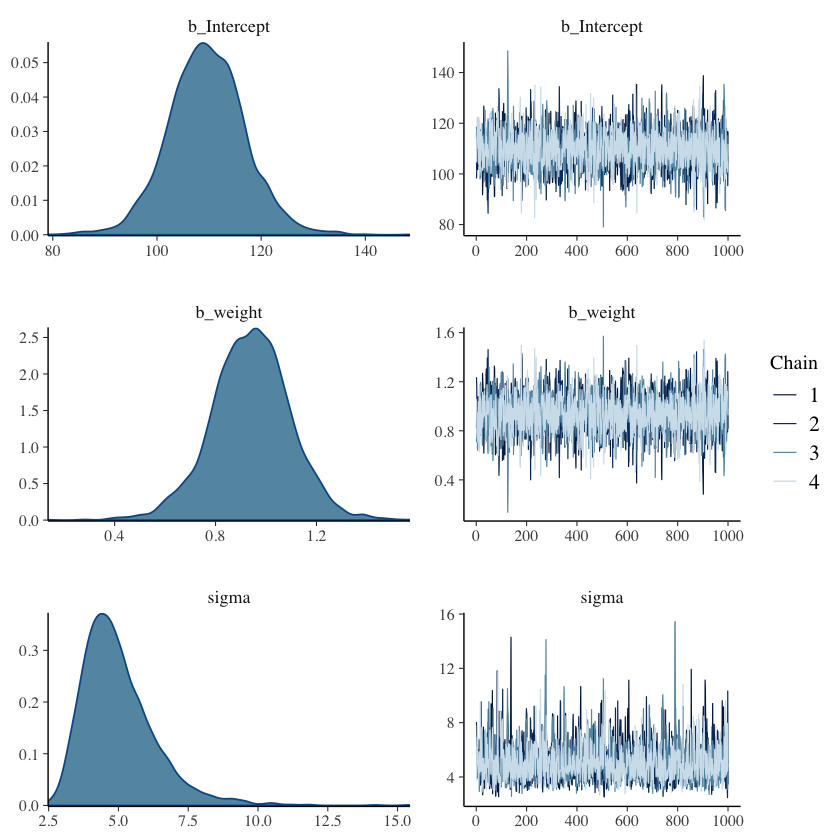

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: height ~ 1 + weight 
   Data: d.adult %>% slice(1:n) (Number of observations: 50) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept   112.98      4.49   104.14   121.82 1.00     3869     2924
weight        0.89      0.10     0.69     1.08 1.00     3823     2959

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     4.94      0.51     4.06     6.06 1.00     3829     2689

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


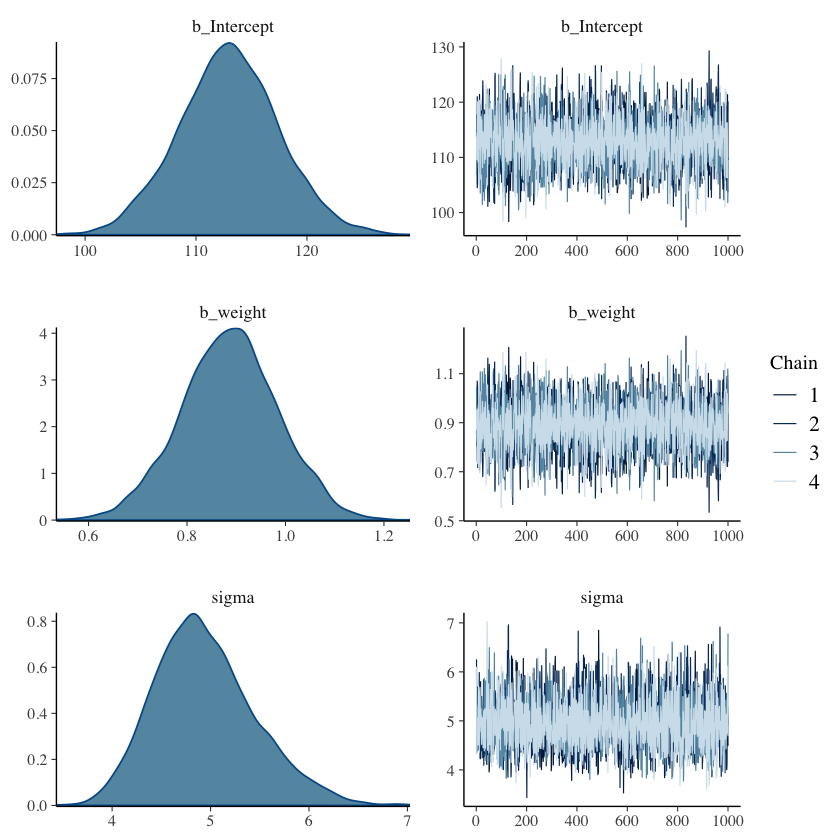

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: height ~ 1 + weight 
   Data: d.adult %>% slice(1:n) (Number of observations: 150) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept   113.24      2.97   107.43   119.09 1.00     4542     2684
weight        0.90      0.06     0.77     1.03 1.00     4633     2664

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     5.47      0.32     4.91     6.18 1.00     3316     2322

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


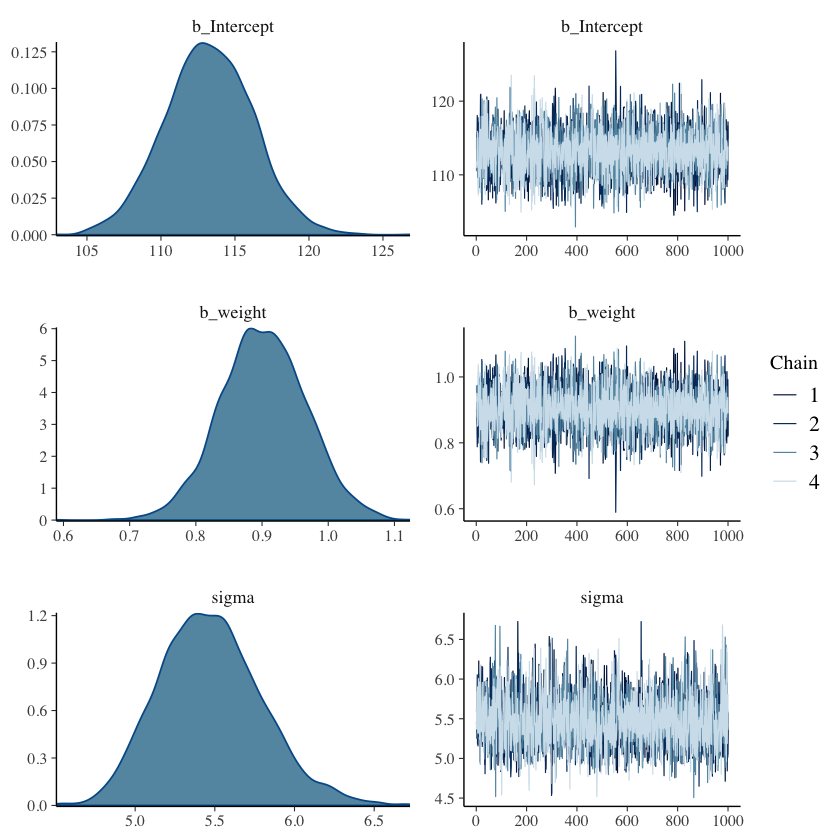

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: height ~ 1 + weight 
   Data: d.adult %>% slice(1:n) (Number of observations: 352) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept   113.95      1.90   110.25   117.59 1.00     4798     3035
weight        0.90      0.04     0.82     0.99 1.00     4845     3194

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     5.09      0.19     4.72     5.48 1.00     3966     3167

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


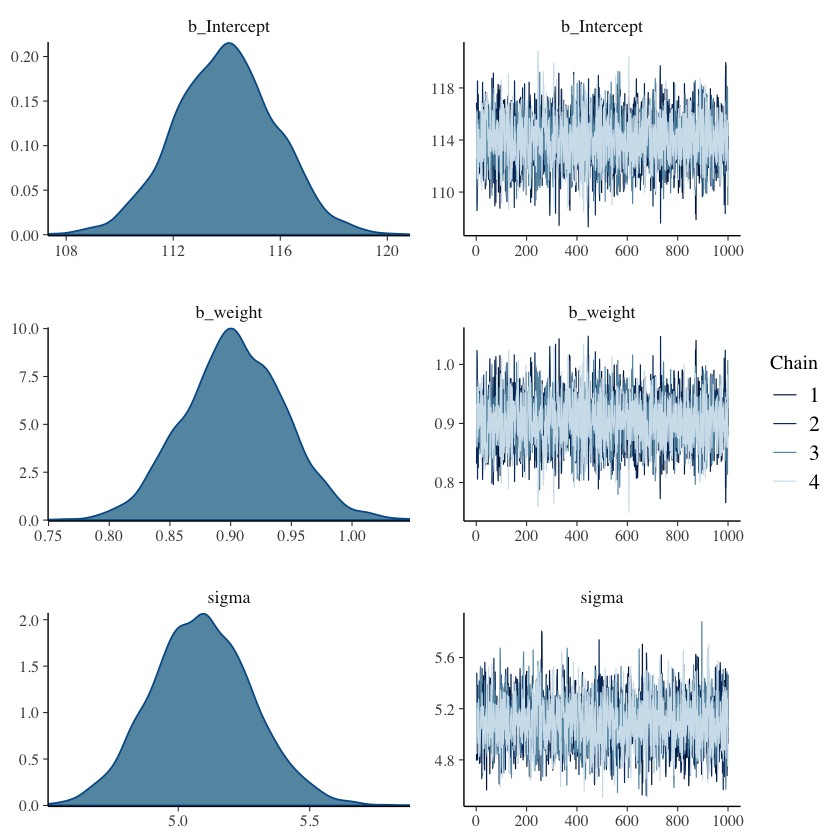

In [33]:
plot(b.10)
print(b.10)

plot(b.50)
print(b.50)

plot(b.150)
print(b.150)

plot(b.352)
print(b.352)

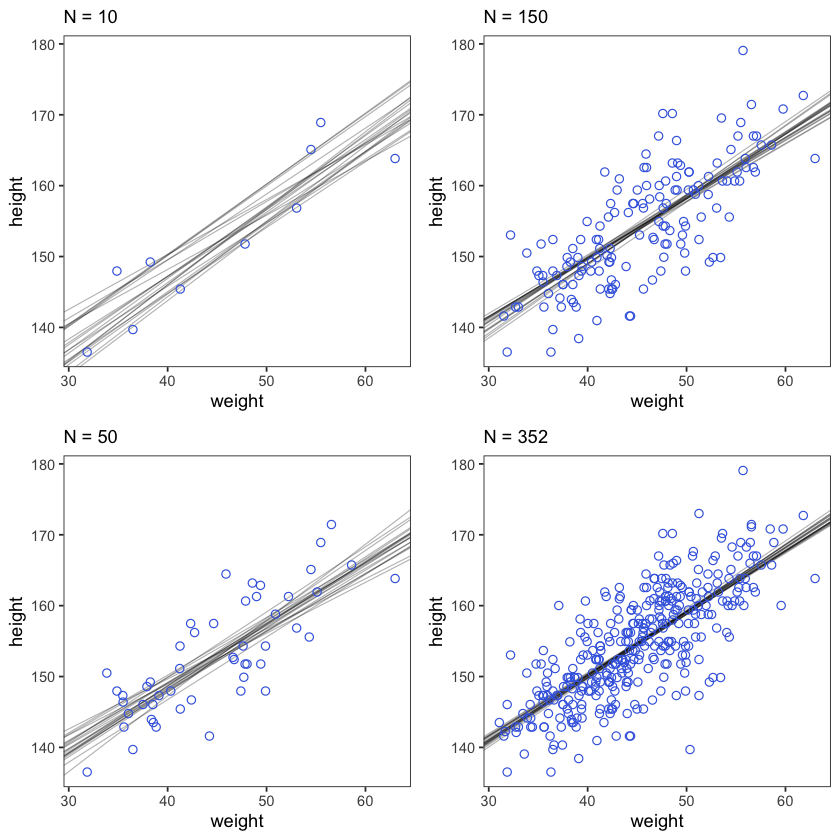

In [37]:
post10  <- posterior_samples(b.10)
post50  <- posterior_samples(b.50)
post150 <- posterior_samples(b.150)
post352 <- posterior_samples(b.352)


p10 <- 
  ggplot(data =  d.adult[1:10 , ], 
         aes(x = weight, y = height)) +
  geom_abline(intercept = post10[1:20, 1], 
              slope     = post10[1:20, 2],
              size = 1/3, alpha = .3) +
  geom_point(shape = 1, size = 2, color = "royalblue") +
  coord_cartesian(xlim = range(d.adult$weight),
                  ylim = range(d.adult$height)) +
  labs(subtitle = "N = 10") +
  theme_bw() +
  theme(panel.grid = element_blank())

p50 <-
  ggplot(data =  d.adult[1:50 , ], 
         aes(x = weight, y = height)) +
  geom_abline(intercept = post50[1:20, 1], 
              slope     = post50[1:20, 2],
              size = 1/3, alpha = .3) +
  geom_point(shape = 1, size = 2, color = "royalblue") +
  coord_cartesian(xlim = range(d.adult$weight),
                  ylim = range(d.adult$height)) +
  labs(subtitle = "N = 50") +
  theme_bw() +
  theme(panel.grid = element_blank())

p150 <-
  ggplot(data =  d.adult[1:150 , ], 
         aes(x = weight, y = height)) +
  geom_abline(intercept = post150[1:20, 1], 
              slope     = post150[1:20, 2],
              size = 1/3, alpha = .3) +
  geom_point(shape = 1, size = 2, color = "royalblue") +
  coord_cartesian(xlim = range(d.adult$weight),
                  ylim = range(d.adult$height)) +
  labs(subtitle = "N = 150") +
  theme_bw() +
  theme(panel.grid = element_blank())

p352 <- 
  ggplot(data =  d.adult[1:352 , ], 
         aes(x = weight, y = height)) +
  geom_abline(intercept = post352[1:20, 1], 
              slope     = post352[1:20, 2],
              size = 1/3, alpha = .3) +
  geom_point(shape = 1, size = 2, color = "royalblue") +
  coord_cartesian(xlim = range(d.adult$weight),
                  ylim = range(d.adult$height)) +
  labs(subtitle = "N = 352") +
  theme_bw() +
  theme(panel.grid = element_blank())

cowplot::plot_grid(p10, p150, p50, p352, nrow = 2, ncol = 2)

### 体重预测

In [38]:
mu_at_50 <- 
  post %>% 
  transmute(mu_at_50 = b_Intercept + b_weight * 50)
 
head(mu_at_50)    #对体重为50kg的预测

mu_at_50
1 159.4806
2 159.5932
3 159.1343
4 159.1228
5 158.5962
6 158.9866

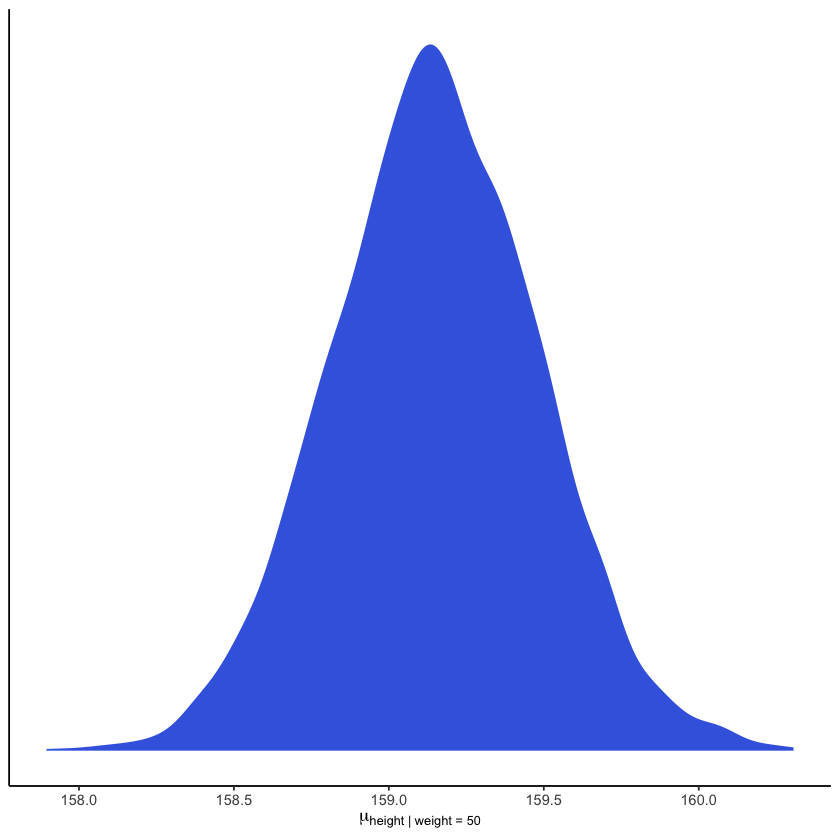

In [50]:
ggplot(mu_at_50, aes(x = mu_at_50)) +
geom_density(size = 0, fill = "royalblue") +
scale_y_continuous(NULL, breaks = NULL) +
labs(x = expression(mu["height | weight = 50"])) +
theme_classic()

In [5]:
library(tidybayes)

In [46]:
mean_hdi(mu_at_50[,1], .width = c(.89, .95))    #均值

y        ymin     ymax     .width .point .interval
1 159.1493 158.6298 159.6907 0.89   mean   hdi      
2 159.1493 158.4474 159.7542 0.95   mean   hdi

In [51]:
median_hdi(mu_at_50[,1], .width = c(.89, .95))    #中位数

y        ymin     ymax     .width .point .interval
1 159.1465 158.6298 159.6907 0.89   median hdi      
2 159.1465 158.4474 159.7542 0.95   median hdi

In [52]:
mode_hdi(mu_at_50[,1], .width = c(.89, .95))    #众数

y        ymin     ymax     .width .point .interval
1 159.1355 158.6298 159.6907 0.89   mode   hdi      
2 159.1355 158.4474 159.7542 0.95   mode   hdi

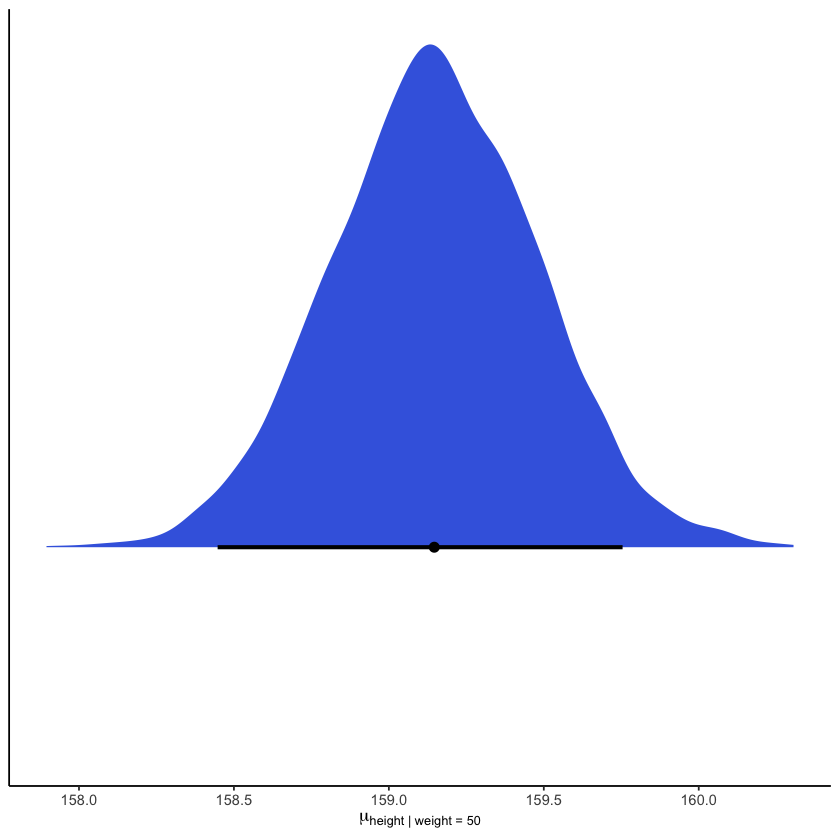

In [56]:
mu_at_50 %>%
  ggplot(aes(x = mu_at_50)) +
  geom_density(size = 0, fill = "royalblue") +
  stat_pointintervalh(aes(y = 0), 
                      point_interval = median_hdi, .width = .95) +
  scale_y_continuous(NULL, breaks = NULL) +
  labs(x = expression(mu["height | weight = 50"])) +
  theme_classic()

`brms::fitted()`使用模型中的公式为给定的一组预测值，计算模型给出的期望

In [48]:
#返回一个值矩阵，其行数(一行对应一个后验分布样本)与HMC链上的预热后迭代数相同，列数与数据中的情况相同  4000 × 352
mu <- fitted(b4.3, summary = F)    #fitted函数能够使模型拟合结果
str(mu)

 num [1:4000, 1:352] 157 158 157 157 157 ...


In [49]:
weight_seq <- tibble(weight = seq(from = 25, to = 70, by = 1))

mu <-
  fitted(b4.3,
         summary = F,
         newdata = weight_seq) %>%    #尝试25-70kg体重的值，共47列，通过b4.3进行拟合
  as_tibble() %>%
  # here we name the columns after the `weight` values from which they were computed
  set_names(25:70) %>% 
  mutate(iter = 1:n())

str(mu)

Warning message:
“`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session.”


Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	4000 obs. of  47 variables:
 $ 25  : num  137 137 137 137 136 ...
 $ 26  : num  138 138 138 138 137 ...
 $ 27  : num  138 139 139 139 138 ...
 $ 28  : num  139 139 139 140 139 ...
 $ 29  : num  140 140 140 141 139 ...
 $ 30  : num  141 141 141 141 140 ...
 $ 31  : num  142 142 142 142 141 ...
 $ 32  : num  143 143 143 143 142 ...
 $ 33  : num  144 144 144 144 143 ...
 $ 34  : num  145 145 145 145 144 ...
 $ 35  : num  146 146 146 146 145 ...
 $ 36  : num  147 147 147 147 146 ...
 $ 37  : num  148 148 147 148 147 ...
 $ 38  : num  148 149 148 149 148 ...
 $ 39  : num  149 150 149 149 149 ...
 $ 40  : num  150 150 150 150 149 ...
 $ 41  : num  151 151 151 151 150 ...
 $ 42  : num  152 152 152 152 151 ...
 $ 43  : num  153 153 153 153 152 ...
 $ 44  : num  154 154 154 154 153 ...
 $ 45  : num  155 155 155 155 154 ...
 $ 46  : num  156 156 156 156 155 ...
 $ 47  : num  157 157 156 156 156 ...
 $ 48  : num  158 158 157 157 157 ...
 $ 49  : num  159 

In [69]:
mu <- 
  mu %>%
  gather(weight, height, -iter) %>% 
  # We might reformat `weight` to numerals
  mutate(weight = as.numeric(weight))

head(mu)

iter weight height  
1 1    25     136.5854
2 2    25     136.6988
3 3    25     136.7505
4 4    25     137.0378
5 5    25     135.8296
6 6    25     136.2207

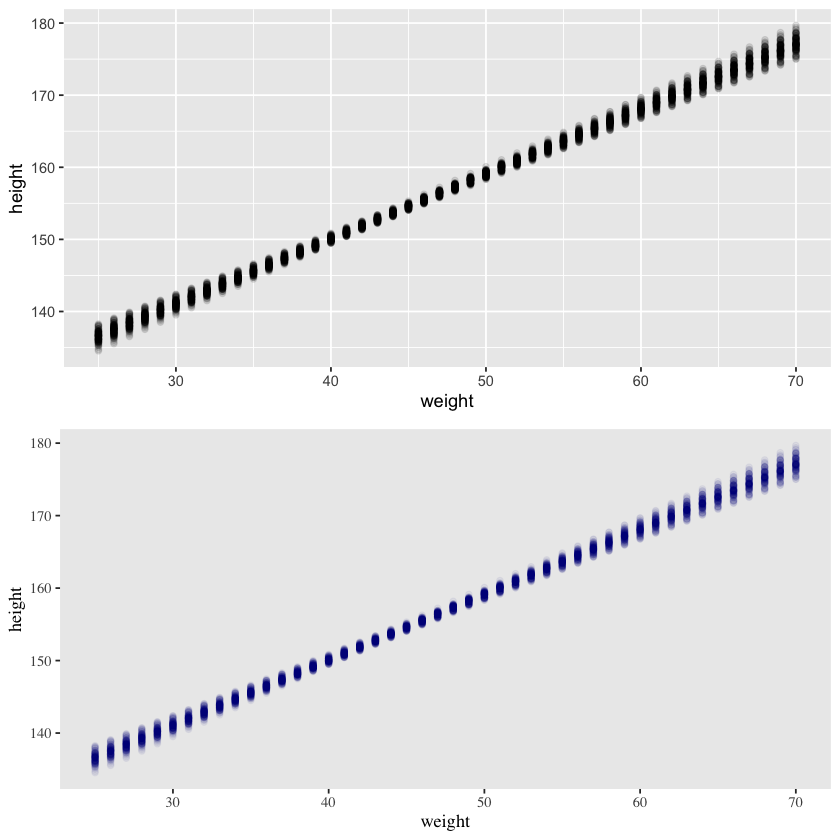

In [71]:
p1 = ggplot(d.adult, aes(x = weight, y = height)) +
  geom_point(data = mu %>% filter(iter < 101),
             alpha = .1)
p2 = ggplot(d.adult, aes(x = weight, y = height)) +
  geom_point(data = mu %>% filter(iter < 101), 
             color = "navyblue", alpha = .05) +
  theme(text = element_text(family = "Times"),
        panel.grid = element_blank())
cowplot::plot_grid(p1, p2, nrow = 2)

In [84]:
mu_summary <-
  fitted(b4.3, 
         newdata = weight_seq) %>%
  as_tibble() %>%
  # let's tack on the `weight` values from `weight_seq`
  bind_cols(weight_seq)

head(mu_summary)

Estimate Est.Error Q2.5     Q97.5    weight
1 136.4623 0.8420192 134.7438 138.0433 25    
2 137.3697 0.8043886 135.7355 138.8787 26    
3 138.2772 0.7669807 136.7297 139.7129 27    
4 139.1847 0.7298298 137.7115 140.5466 28    
5 140.0922 0.6929772 138.6912 141.3807 29    
6 140.9997 0.6564731 139.6772 142.2229 30

In [85]:
head(fitted(b4.3,
            newdata = weight_seq,
            probs = c(.25, .75)))

Estimate Est.Error Q25      Q75     
[1,] 136.4623 0.8420192 135.9047 137.0295
[2,] 137.3697 0.8043886 136.8375 137.9093
[3,] 138.2772 0.7669807 137.7710 138.7944
[4,] 139.1847 0.7298298 138.7095 139.6777
[5,] 140.0922 0.6929772 139.6431 140.5631
[6,] 140.9997 0.6564731 140.5793 141.4462

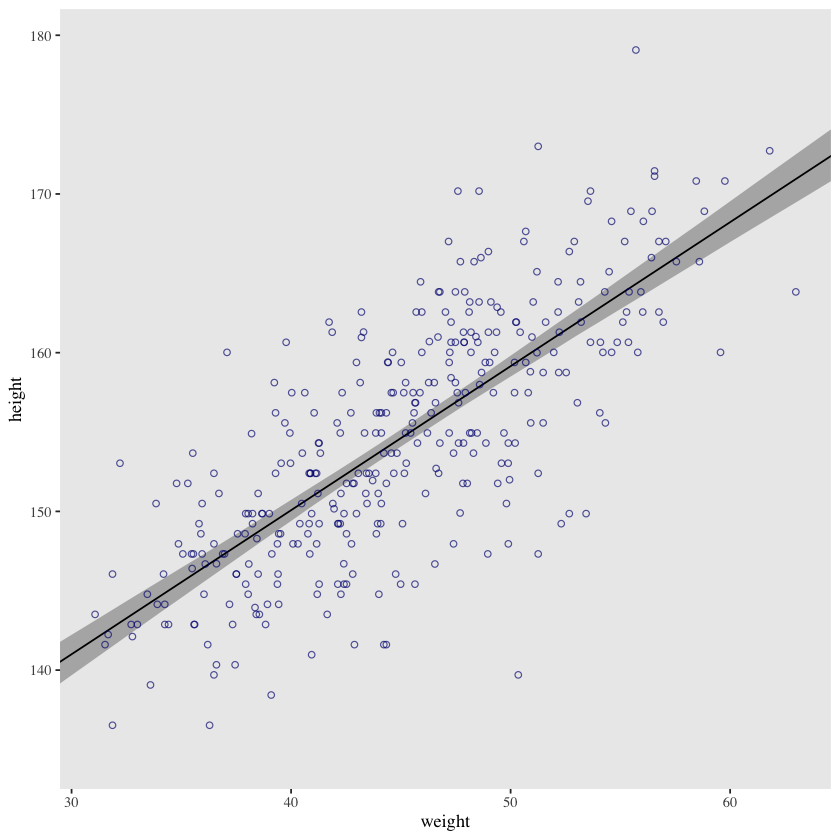

In [76]:
d.adult %>%
  ggplot(aes(x = weight, y = height)) +
  geom_smooth(data = mu_summary,
              aes(y = Estimate, ymin = Q2.5, ymax = Q97.5),    #加上置信区间
              stat = "identity",
              fill = "grey70", color = "black", alpha = 1, size = 1/2) +
  geom_point(color = "navyblue", shape = 1, size = 1.5, alpha = 2/3) +
  coord_cartesian(xlim = range(d.adult$weight)) +
  theme(text = element_text(family = "Times"),
        panel.grid = element_blank())

### 预测区间
$h_{i} \sim \operatorname{Normal}\left(\mu_{i}=\alpha+\beta x, \sigma\right)$

使用`predict`引入由σ表示的变异性 

In [80]:
pred_height <-
  predict(b4.3,
          newdata = weight_seq) %>%   #给定体重从后验中模拟身高
  as_tibble() %>%
  bind_cols(weight_seq)
  
pred_height %>%
  slice(1:6)

Estimate Est.Error Q2.5     Q97.5    weight
1 136.4611 5.128766  126.1853 146.3040 25    
2 137.4711 5.163214  127.2755 147.5765 26    
3 138.2602 5.171253  128.1040 148.4346 27    
4 139.1324 5.241784  128.9884 149.1871 28    
5 140.0155 5.119480  129.8566 150.0646 29    
6 141.0187 5.130558  131.1036 150.9350 30

这些模拟是由𝜇和𝜎共同产生的结果，与`fitted()`只反映μ的结果不同

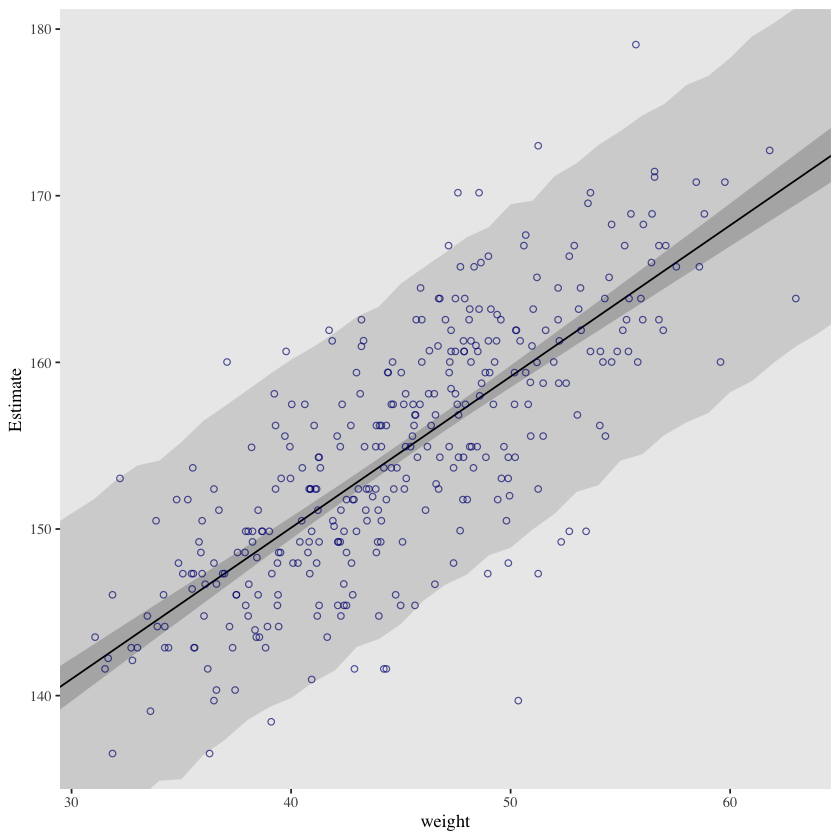

In [81]:
d.adult %>%
  ggplot(aes(x = weight)) +
  geom_ribbon(data = pred_height, 
              aes(ymin = Q2.5, ymax = Q97.5),
              fill = "grey83") +
  geom_smooth(data = mu_summary,
              aes(y = Estimate, ymin = Q2.5, ymax = Q97.5),
              stat = "identity",
              fill = "grey70", color = "black", alpha = 1, size = 1/2) +
  geom_point(aes(y = height),
             color = "navyblue", shape = 1, size = 1.5, alpha = 2/3) +
  coord_cartesian(xlim = range(d.adult$weight),
                  ylim = range(d.adult$height)) +
  theme(text = element_text(family = "Times"),
        panel.grid = element_blank())

# 多项式回归

## 二次函数
$\mu=\alpha+\beta_{1} x_{i}+\beta_{2} x_{i}^{2}$

In [9]:
glimpse(d)

Observations: 544
Variables: 4
$ height <dbl> 151.7650, 139.7000, 136.5250, 156.8450, 145.4150, 163.8300, 1…
$ weight <dbl> 47.82561, 36.48581, 31.86484, 53.04191, 41.27687, 62.99259, 3…
$ age    <dbl> 63.0, 63.0, 65.0, 41.0, 51.0, 35.0, 32.0, 27.0, 19.0, 54.0, 4…
$ male   <int> 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0…


In [16]:
d <-
  d %>%
    mutate(weight_s = scale(weight))
#   mutate(weight_s = (weight - mean(weight)) / sd(weight))
head(d)

height  weight   age male weight_s   
1 151.765 47.82561 63  1     0.82986895
2 139.700 36.48581 63  0     0.05945909
3 136.525 31.86484 65  0    -0.25448293
4 156.845 53.04191 41  1     1.18425748
5 145.415 41.27687 51  0     0.38495725
6 163.830 62.99259 35  1     1.86029214

In [15]:
b4.5 <- 
  brm(data = d, family = gaussian,
      height ~ 1 + weight_s + I(weight_s^2),
      prior = c(prior(normal(178, 100), class = Intercept),
                prior(normal(0, 10), class = b),
                prior(cauchy(0, 1), class = sigma)),
      iter = 2000, warmup = 1000, chains = 4, cores = 4,
      seed = 4)

Compiling the C++ model

Start sampling



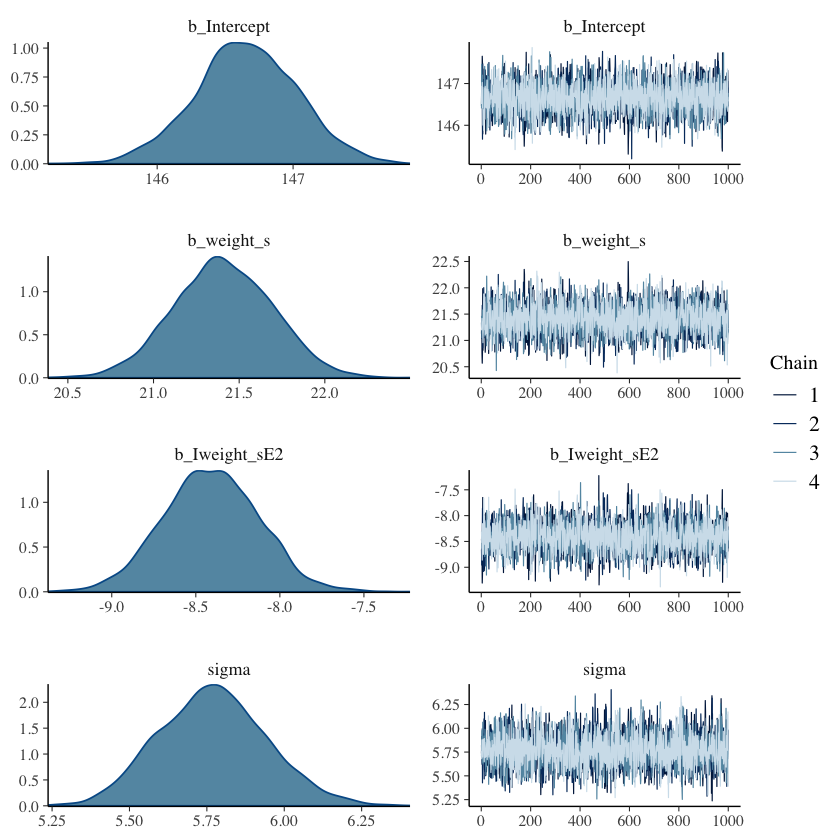

In [17]:
plot(b4.5)

In [18]:
print(b4.5)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: height ~ 1 + weight_s + I(weight_s^2) 
   Data: d (Number of observations: 544) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     146.66      0.38   145.90   147.40 1.00     3614     3030
weight_s       21.41      0.29    20.84    21.97 1.00     3526     3134
Iweight_sE2    -8.41      0.28    -8.96    -7.86 1.00     3515     3091

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     5.77      0.17     5.44     6.12 1.00     3701     2807

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


In [19]:
weight_seq <- tibble(weight_s = seq(from = -2.5, to = 2.5, length.out = 30))

f_quad <-
  fitted(b4.5, 
         newdata = weight_seq) %>%
  as_tibble() %>%
  bind_cols(weight_seq)

p_quad <-
  predict(b4.5, 
          newdata = weight_seq) %>%
  as_tibble() %>%
  bind_cols(weight_seq)  

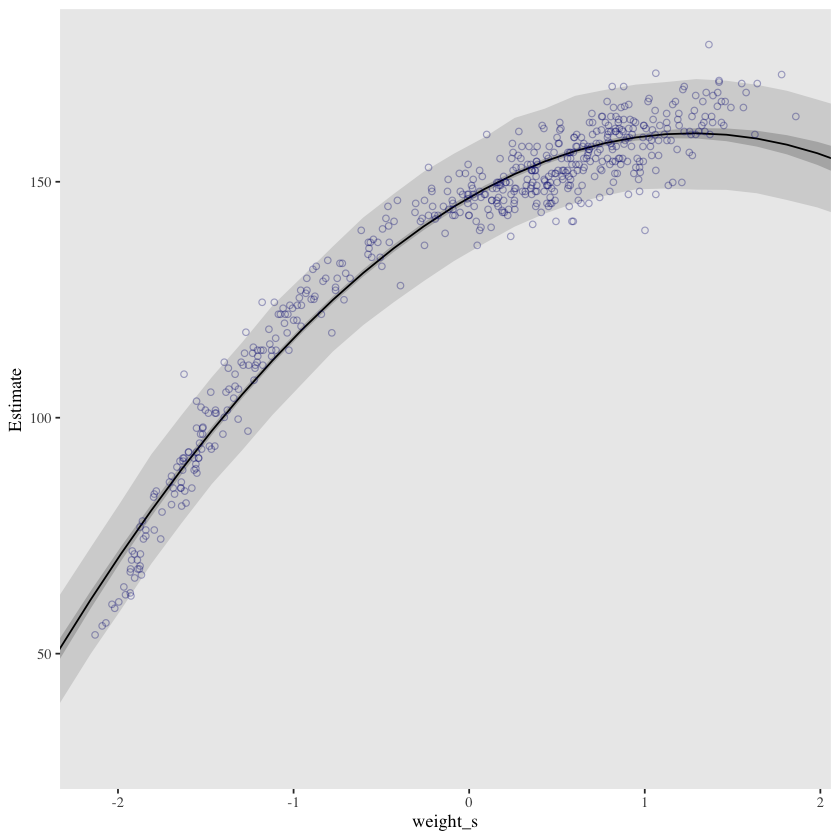

In [20]:
ggplot(data = d, 
       aes(x = weight_s)) +
  geom_ribbon(data = p_quad, 
              aes(ymin = Q2.5, ymax = Q97.5),
              fill = "grey83") +
  geom_smooth(data = f_quad,
              aes(y = Estimate, ymin = Q2.5, ymax = Q97.5),
              stat = "identity",
              fill = "grey70", color = "black", alpha = 1, size = 1/2) +
  geom_point(aes(y = height),
             color = "navyblue", shape = 1, size = 1.5, alpha = 1/3) +
  coord_cartesian(xlim = range(d$weight_s)) +
  theme(text = element_text(family = "Times"),
        panel.grid = element_blank())

## 三次函数
$\mu=\alpha+\beta_{1} x_{i}+\beta_{2} x_{i}^{2}+\beta_{3} x_{i}^{3}$

In [21]:
b4.6 <- 
  brm(data = d, family = gaussian,
      height ~ 1 + weight_s + I(weight_s^2) + I(weight_s^3),
      prior = c(prior(normal(178, 100), class = Intercept),
                prior(normal(0, 10), class = b),
                prior(cauchy(0, 1), class = sigma)),
      iter = 2000, warmup = 1000, chains = 4, cores = 4,
      seed = 4)

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling



In [22]:
b4.7 <- 
  brm(data = d, family = gaussian,
      height ~ 1 + weight_s,
      prior = c(prior(normal(178, 100), class = Intercept),
                prior(normal(0, 10), class = b),
                prior(cauchy(0, 1), class = sigma)),
      iter = 2000, warmup = 1000, chains = 4, cores = 4,
      seed = 4)

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling



In [26]:
f_cub <-
  fitted(b4.6, 
         newdata = weight_seq) %>%
  as_tibble() %>%
  bind_cols(weight_seq)

p_cub <-
  predict(b4.6, 
          newdata = weight_seq) %>%
  as_tibble() %>%
  bind_cols(weight_seq) 

p3 = ggplot(data = d, 
       aes(x = weight_s)) +
  geom_ribbon(data = p_cub, 
              aes(ymin = Q2.5, ymax = Q97.5),
              fill = "grey83") +
  geom_smooth(data = f_cub,
              aes(y = Estimate, ymin = Q2.5, ymax = Q97.5),
              stat = "identity",
              fill = "grey70", color = "black", alpha = 1, size = 1/4) +
  geom_point(aes(y = height),
             color = "navyblue", shape = 1, size = 1.5, alpha = 1/3) +
  coord_cartesian(xlim = range(d$weight_s)) +
  theme(text = element_text(family = "Times"),
        panel.grid = element_blank())

In [24]:
f_line <-
  fitted(b4.7, 
         newdata = weight_seq) %>%
  as_tibble() %>%
  bind_cols(weight_seq)

p_line <-
  predict(b4.7, 
          newdata = weight_seq) %>%
  as_tibble() %>%
  bind_cols(weight_seq) 

p1 = ggplot(data = d, 
       aes(x = weight_s)) +
  geom_ribbon(data = p_line, 
              aes(ymin = Q2.5, ymax = Q97.5),
              fill = "grey83") +
  geom_smooth(data = f_line,
              aes(y = Estimate, ymin = Q2.5, ymax = Q97.5),
              stat = "identity",
              fill = "grey70", color = "black", alpha = 1, size = 1/4) +
  geom_point(aes(y = height),
             color = "navyblue", shape = 1, size = 1.5, alpha = 1/3) +
  coord_cartesian(xlim = range(d$weight_s)) +
  theme(text = element_text(family = "Times"),
        panel.grid = element_blank())

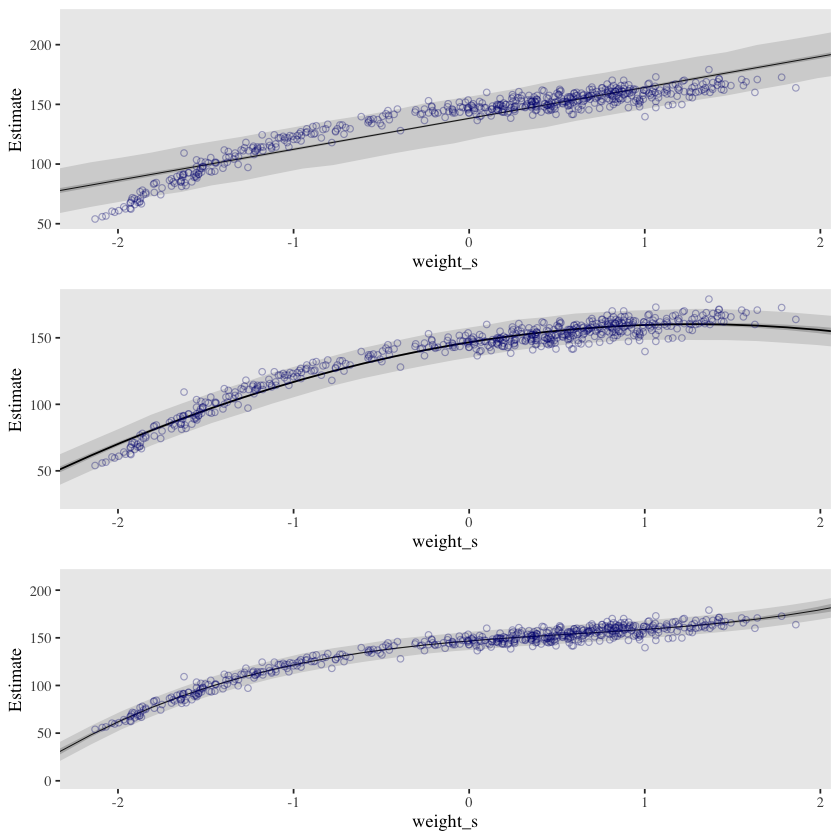

In [27]:
p2 = ggplot(data = d, 
       aes(x = weight_s)) +
  geom_ribbon(data = p_quad, 
              aes(ymin = Q2.5, ymax = Q97.5),
              fill = "grey83") +
  geom_smooth(data = f_quad,
              aes(y = Estimate, ymin = Q2.5, ymax = Q97.5),
              stat = "identity",
              fill = "grey70", color = "black", alpha = 1, size = 1/2) +
  geom_point(aes(y = height),
             color = "navyblue", shape = 1, size = 1.5, alpha = 1/3) +
  coord_cartesian(xlim = range(d$weight_s)) +
  theme(text = element_text(family = "Times"),
        panel.grid = element_blank())

cowplot::plot_grid(p1, p2, p3, nrow = 3)

## 转回原尺度

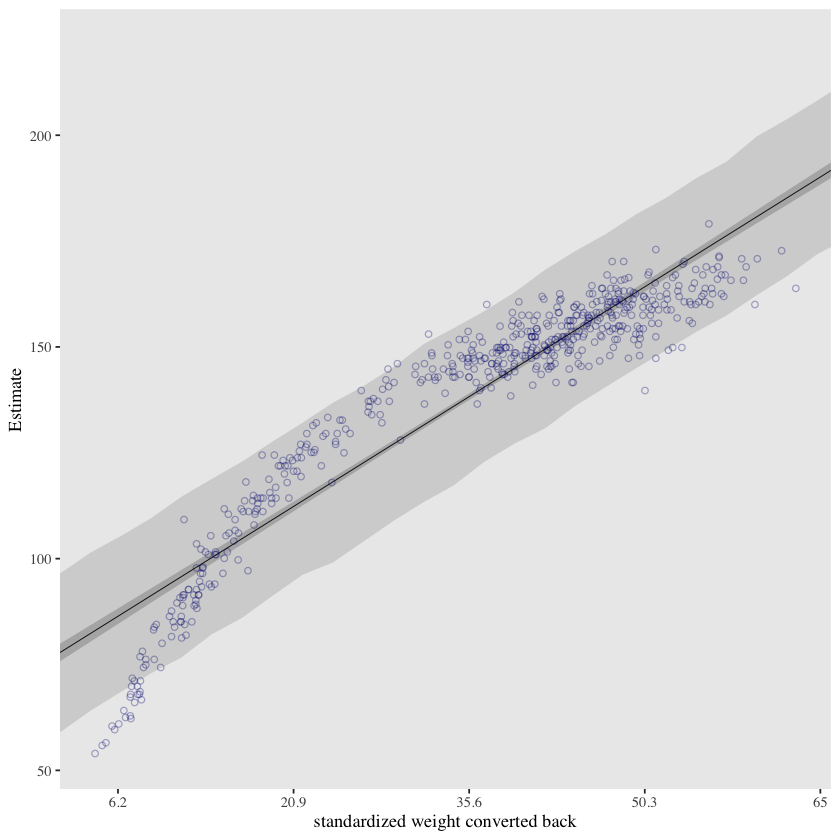

In [28]:
at <- c(-2, -1, 0, 1, 2)

ggplot(data = d, 
       aes(x = weight_s)) +
  geom_ribbon(data = p_line, 
              aes(ymin = Q2.5, ymax = Q97.5),
              fill = "grey83") +
  geom_smooth(data = f_line,
              aes(y = Estimate, ymin = Q2.5, ymax = Q97.5),
              stat = "identity",
              fill = "grey70", color = "black", alpha = 1, size = 1/4) +
  geom_point(aes(y = height),
             color = "navyblue", shape = 1, size = 1.5, alpha = 1/3) +
  coord_cartesian(xlim = range(d$weight_s)) +
  theme(text = element_text(family = "Times"),
        panel.grid = element_blank()) +
  
  # here it is!
  scale_x_continuous("standardized weight converted back",
                     breaks = at,
                     labels = round(at * sd(d$weight) + mean(d$weight), 1))

In [29]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Catalina 10.15.3

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRlapack.dylib

locale:
[1] zh_CN.UTF-8/zh_CN.UTF-8/zh_CN.UTF-8/C/zh_CN.UTF-8/zh_CN.UTF-8

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] forcats_0.4.0        stringr_1.4.0        dplyr_0.8.4         
 [4] purrr_0.3.3          readr_1.3.1          tidyr_1.0.2         
 [7] tibble_2.1.3         tidyverse_1.3.0      tidybayes_2.0.1     
[10] brms_2.11.1          Rcpp_1.0.3           dagitty_0.2-2       
[13] rstan_2.19.3         ggplot2_3.2.1        StanHeaders_2.21.0-1

loaded via a namespace (and not attached):
  [1] colorspace_1.4-1     ggridges_0.5.2       rsconnect_0.8.16    
  [4] IRdisplay_0.7.0      